<a href="https://colab.research.google.com/github/belanatal/PosPUCRio/blob/main/MVP-SprintIIa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint I: Análise de Dados e Boas Práticas (40530010055_20230_01)**

Aluna: Isabela Fernanda Natal Batista Abreu Gomes

Maio/2023

# **Introdução**

## Programa para obtenção, tratamento e análise do histórico de Energia Natural Afluente (ENA), da Energia Armazenada (EArm), da Demanda/Carga e do Custo Marginal da Operação (CMO) por subsistema, a partir da área de Dados Abertos do Operador Nacional do Sistema Elétrico (ONS): [Arquitetura Aberta](https://dados.ons.org.br/)

> Bloco com recuo




> No Brasil, a projeção de preços da energia elétrica baseia-se na previsão, centralizada, de despacho das usinas pelo Operador Nacional do Sistema Elétrico (ONS).

> Em linhas gerais, o preço da energia, também chamado de Preço de Liquidação das Diferenças (PLD) tem como base o Custo Marginal da Operação (CMO), dado pelo planejamento da operação hidrotérmica do Sistema Interligado Nacional. Os modelos utilizados para projeção oficial do despacho das usinas pelo ONS (Operador Nacional do Sistema) denominam-se NEWAVE, DECOMP e DESSEM, todos desenvolvidos e fornecidos pelo Centro de Pesquisas da Eletrobras (CEPEL), conforme ilustrado na Figura 1.

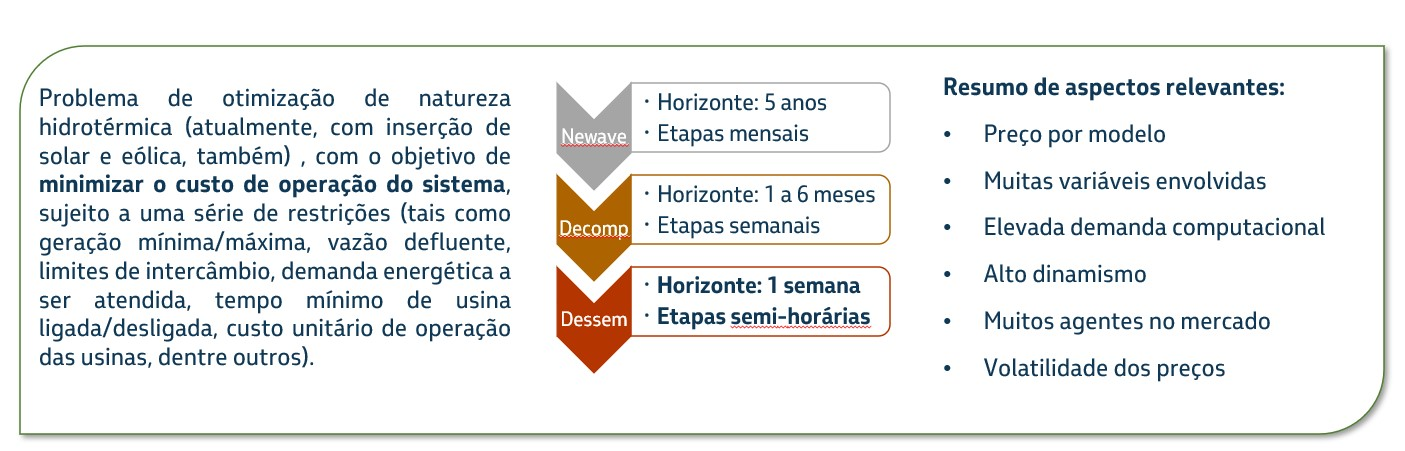

Figura 1 - Resumo do problema de planejamento eletroenergético brasileiro.

> Para a projeção do preço da energia elétrica, uma série de grandezas são utilizadas como entrada. Uma vez que a matriz eletroenergética brasileira é predominantemente hidráulica (e os modelos consideram este aspecto no equacionamento do problema de otimização), a diferença entre as vazões previstas e verificadas dos postos associados às usinas hidroelétricas responde por cerca de 50% das variações no PLD/CMO, conforme ilustrado na Figura 2, disponibilizada pela Câmara de Comercialização de Energia (CCEE). A Energia Armazenada e a Carga também desempenham papel relevante na influência do PLD/CMO. Juntas, as três grandezas respondem por mais de 70% das variações no custo marginal da operação sendo, portanto, as variáveis de interesse na primeira abordagem deste MVP.

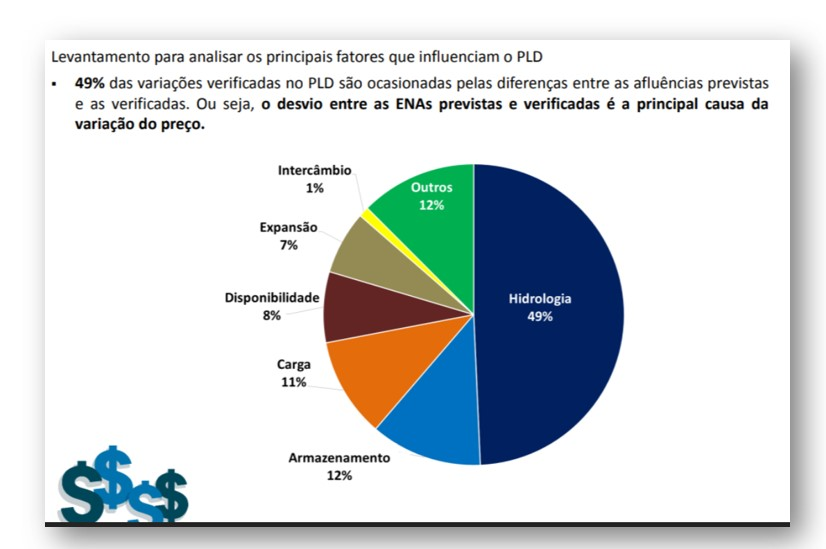

Figura 2 - Variação do PLD/CMO por variável de entrada nos modelos de planejamento eletroenergético do SIN. Fonte: CCEE


> Neste contexto, considerando a atuação na área de Inteligência de Mercado de Gás e Energia em um dos principais agentes geradores do Brasil, faz sentido estruturarmos a coleta e tratamento dos dados referentes às grandezas mencionadas, visando à melhor tomada de decisão sob a ótica da operação do parque e da comercialização e logística do gás e da energia elétrica.





# **Seção I: Obtenção e Tratamento Inicial dos Dados**


1.   [Energia Natural Afluente (ENA) por Subsistema](https://dados.ons.org.br/dataset/ena-diario-por-subsistema)
2.   [Energia Armazenada (EArm) por Subsistema](https://dados.ons.org.br/dataset/ear-diario-por-subsistema)
3.   [Demanda por Subsistema](https://dados.ons.org.br/dataset/carga-energia)
4.   [Custo Marginal da Operação (CMO) Semanal por Subsistema](https://dados.ons.org.br/dataset/cmo-semanal)





> Diariamente, o Operador Nacional do Sistema Elétrico disponibiliza os dados verificados das grandezas supracitadas, para cada um dos 4 subsistemas (Sudeste, Sul, Nordeste e Norte) que compõem eletroenergeticamente o Sistema Interligado Nacional. Para atender ao presente trabalho, estes dados serão tratados, manipulados, pré-processados e avaliados de modo que, em etapas futuras, seja possível aplicar técnicas e algoritmos de Machine Learning a eles, com o objetivo de tentar realizar predições e análises de sensibilidade de Custos Marginais da Operação futuros, por fora dos modelos oficiais.

> Trata-se, portanto, de um problema de Aprendizado Supervisionado, considerando as principais grandezas envolvidas no cálculo do CMO, segundo a Câmara de Comercialização de Energia.



Inicialmente, iremos importar e avaliar (utilizando a biblioteca Pandas, para fazer uma rápida análise exploratória) os dataset de "entrada", variáveis explicativas para a obtenção do CMO: ENA, EArm e Demanda, nesta ordem.

In [227]:
# Primeiro bloco: Importação das bibliotecas e módulos
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
#
# Importando as bibliotecas pandas, matplotlib (pyplot), seaborn e datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
#
## Transformações Numéricas e ML
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV # para tuning dos hiperparâmetros dos estimadores
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import LogisticRegression # algoritmo Regressão Logística
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM
#
## Para aplicação de métodos ensemble em ML
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor #similar ao GradientBoostingRegressor mas, de acordo com a biblioteca do scikitlearn, mais rápido
#
## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Energia Natural Afluente: ENA

***ENA DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia natural afluente (ENA) dos reservatórios com periodicidade diária por Subsistemas.

A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [228]:
# Seção I.1: Programa para obtenção das Energias Naturais Afluentes - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.
# ENA - Arquivos com os dados anuais, com histórico desde 2001
ano_zero=2001
ano_inicio=ano_zero+1
data_fim=datetime.datetime.now() - datetime.timedelta(days=5) #ano vigente, considerando um possível atraso de até 5 dias na publicação, o que é comum na virada de ano
ano_fim=data_fim.strftime("%Y")
ano_fim=int(ano_fim)
print(data_fim)
print(ano_fim)

2023-07-02 16:59:43.544374
2023


In [229]:
#Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
#Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ena=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
ena=pd.DataFrame(ena)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    ena_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    ena_ano=pd.DataFrame(ena_ano)
    ena=pd.concat([ena,ena_ano])
print(ena)

    id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0               N          NORTE  2001-01-01            10154.000000   
1              NE       NORDESTE  2001-01-01            13472.000000   
2               S            SUL  2001-01-01             7703.000000   
3              SE        SUDESTE  2001-01-01            39186.000000   
4               N          NORTE  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
739            SE        SUDESTE  2023-07-04            23858.396484   
740             N          NORTE  2023-07-05             5215.491211   
741            NE       NORDESTE  2023-07-05             2068.459961   
742             S            SUL  2023-07-05             4898.884766   
743            SE        SUDESTE  2023-07-05            23404.642578   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [230]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
ena.head(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0             N          NORTE  2001-01-01                 10154.0   
1            NE       NORDESTE  2001-01-01                 13472.0   
2             S            SUL  2001-01-01                  7703.0   
3            SE        SUDESTE  2001-01-01                 39186.0   
4             N          NORTE  2001-01-02                  9590.0   
5            NE       NORDESTE  2001-01-02                 13551.0   
6             S            SUL  2001-01-02                  6730.0   
7            SE        SUDESTE  2001-01-02                 41230.0   
8             N          NORTE  2001-01-03                  9066.0   
9            NE       NORDESTE  2001-01-03                 13551.0   

   ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                      122.339996                        9033.0   
1                      101.480003                       13385.0   
2                      160.910004                        7703.0   
3                       86.980003                       37611.0   
4                      115.550003                        8091.0   
5                      102.080002                       13465.0   
6                      140.580002                        6730.0   
7                       91.519997                       40063.0   
8                      109.239998                        7213.0   
9                      102.080002                       13461.0   

   ena_armazenavel_regiao_percentualmlt  
0                            108.839996  
1                            100.830002  
2                            160.910004  
3                             83.489998  
4                             97.489998  
5                            101.430000  
6                            140.580002  
7                             88.930000  
8                             86.910004  
9                            101.400002

In [231]:
# Conferindo as últimas 10 linhas
ena.tail(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
734             S            SUL  2023-07-03             5562.437988   
735            SE        SUDESTE  2023-07-03            24312.062500   
736             N          NORTE  2023-07-04             5285.913086   
737            NE       NORDESTE  2023-07-04             2065.939941   
738             S            SUL  2023-07-04             5203.958984   
739            SE        SUDESTE  2023-07-04            23858.396484   
740             N          NORTE  2023-07-05             5215.491211   
741            NE       NORDESTE  2023-07-05             2068.459961   
742             S            SUL  2023-07-05             4898.884766   
743            SE        SUDESTE  2023-07-05            23404.642578   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
734                       50.873501                   5503.061035   
735                       94.803299                  24044.876953   
736                      100.477600                   5038.742188   
737                       54.726501                   2045.920044   
738                       47.594898                   5097.763184   
739                       93.034302                  23358.947266   
740                       99.139000                   4969.685059   
741                       54.793301                   2030.621948   
742                       44.804798                   4767.125000   
743                       91.264900                  22735.201172   

     ena_armazenavel_regiao_percentualmlt  
734                             50.330502  
735                             93.761398  
736                             95.779198  
737                             54.196201  
738                             46.623699  
739                             91.086700  
740                             94.466499  
741                             53.790901  
742                             43.599701  
743                             88.654404

In [232]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(ena)/4

8221.0

In [233]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                            object
nom_subsistema                           object
ena_data                                 object
ena_bruta_regiao_mwmed                  float64
ena_bruta_regiao_percentualmlt          float64
ena_armazenavel_regiao_mwmed            float64
ena_armazenavel_regiao_percentualmlt    float64
dtype: object

In [234]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
ena['nom_subsistema']=ena['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [235]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
ena=ena.rename(columns = {'ena_data':'Data'})
print(ena)

    id_subsistema nom_subsistema        Data  ena_bruta_regiao_mwmed  \
0               N          Norte  2001-01-01            10154.000000   
1              NE       Nordeste  2001-01-01            13472.000000   
2               S            Sul  2001-01-01             7703.000000   
3              SE        Sudeste  2001-01-01            39186.000000   
4               N          Norte  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
739            SE        Sudeste  2023-07-04            23858.396484   
740             N          Norte  2023-07-05             5215.491211   
741            NE       Nordeste  2023-07-05             2068.459961   
742             S            Sul  2023-07-05             4898.884766   
743            SE        Sudeste  2023-07-05            23404.642578   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [236]:
# Alterando o tipo da coluna "Data"
ena['Data'] = pd.to_datetime(ena['Data'])

In [237]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                                   object
nom_subsistema                                  object
Data                                    datetime64[ns]
ena_bruta_regiao_mwmed                         float64
ena_bruta_regiao_percentualmlt                 float64
ena_armazenavel_regiao_mwmed                   float64
ena_armazenavel_regiao_percentualmlt           float64
dtype: object

In [238]:
# Reordenando o dataframe ena, pela coluna Data (em ordem decrescente)
ena=ena.sort_values(by='Data', ascending=False)
ena.head(20)

id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
743            SE        Sudeste 2023-07-05            23404.642578   
742             S            Sul 2023-07-05             4898.884766   
741            NE       Nordeste 2023-07-05             2068.459961   
740             N          Norte 2023-07-05             5215.491211   
739            SE        Sudeste 2023-07-04            23858.396484   
738             S            Sul 2023-07-04             5203.958984   
737            NE       Nordeste 2023-07-04             2065.939941   
736             N          Norte 2023-07-04             5285.913086   
733            NE       Nordeste 2023-07-03             2066.144043   
732             N          Norte 2023-07-03             5352.596191   
735            SE        Sudeste 2023-07-03            24312.062500   
734             S            Sul 2023-07-03             5562.437988   
731            SE        Sudeste 2023-07-02            24907.822266   
730             S            Sul 2023-07-02             6030.276855   
729            NE       Nordeste 2023-07-02             2066.417969   
728             N          Norte 2023-07-02             5436.038086   
725            NE       Nordeste 2023-07-01             2061.402100   
724             N          Norte 2023-07-01             5525.350098   
727            SE        Sudeste 2023-07-01            25502.728516   
726             S            Sul 2023-07-01             6642.918945   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
743                       91.264900                  22735.201172   
742                       44.804798                   4767.125000   
741                       54.793301                   2030.621948   
740                       99.139000                   4969.685059   
739                       93.034302                  23358.947266   
738                       47.594898                   5097.763184   
737                       54.726501                   2045.920044   
736                      100.477600                   5038.742188   
733                       54.731899                   2043.264038   
732                      101.745102                   5127.242188   
735                       94.803299                  24044.876953   
734                       50.873501                   5503.061035   
731                       97.126404                  23998.900391   
730                       55.152401                   5856.448242   
729                       54.739201                   2042.108032   
728                      103.331200                   5180.610840   
725                       54.606300                   2052.106934   
724                      105.028900                   5310.791016   
727                       99.446198                  25069.007812   
726                       60.755501                   6579.297852   

     ena_armazenavel_regiao_percentualmlt  
743                             88.654404  
742                             43.599701  
741                             53.790901  
740                             94.466499  
739                             91.086700  
738                             46.623699  
737                             54.196201  
736                             95.779198  
733                             54.125801  
732                             97.461502  
735                             93.761398  
734                             50.330502  
731                             93.582199  
730                             53.562500  
729                             54.095200  
728                             98.475899  
725                             54.360100  
724                            100.950500  
727                             97.754997  
726                             60.173698

## Energia Armazenada: EArm

***EAR DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia armazenada (EAR) em periodicidade diária por Subsistemas.

A Energia Armazenada (EAR) representa a energia associada ao volume de água disponível nos reservatórios que pode ser convertido em geração na própria usina e em todas as usinas à jusante na cascata. A grandeza de EAR leva em conta nível verificado nos reservatórios na data de referência. A grandeza de EAR máxima representa a capacidade de armazenamento caso todos os reservatórios do sistema estivessem cheios. A grandeza de EAR para o subsistema à jusante considera a utilização da água do reservatório para produzir energia em uma usina à jusante que está em um subsistema diferente.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [239]:
# Seção I.2: Programa para obtenção das Energias Armazenadas - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# EArm - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
earm=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
earm=pd.DataFrame(earm)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    earm_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    earm_ano=pd.DataFrame(earm_ano)
    earm=pd.concat([earm,earm_ano])
print (earm)

    id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0              NE       NORDESTE  2001-01-01        49967.000000   
1               N          NORTE  2001-01-01        12311.000000   
2              SE        SUDESTE  2001-01-01       159081.000000   
3               S            SUL  2001-01-01        14176.000000   
4              NE       NORDESTE  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
739             S            SUL  2023-07-04        20459.242188   
740            NE       NORDESTE  2023-07-05        51691.226562   
741             N          NORTE  2023-07-05        15302.396484   
742            SE        SUDESTE  2023-07-05       204615.328125   
743             S            SUL  2023-07-05        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [240]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
earm.head(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0            NE       NORDESTE  2001-01-01             49967.0   
1             N          NORTE  2001-01-01             12311.0   
2            SE        SUDESTE  2001-01-01            159081.0   
3             S            SUL  2001-01-01             14176.0   
4            NE       NORDESTE  2001-01-02             49967.0   
5             N          NORTE  2001-01-02             12311.0   
6            SE        SUDESTE  2001-01-02            159081.0   
7             S            SUL  2001-01-02             14176.0   
8            NE       NORDESTE  2001-01-03             49967.0   
9             N          NORTE  2001-01-03             12311.0   

   ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                     18699.0                        37.419998  
1                      9137.0                        74.220001  
2                     46315.0                        29.110001  
3                     12857.0                        90.690002  
4                     18851.0                        37.730000  
5                      9327.0                        75.760002  
6                     46850.0                        29.450001  
7                     12920.0                        91.139999  
8                     19047.0                        38.119999  
9                      9453.0                        76.779999

In [241]:
# Conferindo as últimas 10 linhas
earm.tail(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
734            SE        SUDESTE  2023-07-03       204615.328125   
735             S            SUL  2023-07-03        20459.242188   
736            NE       NORDESTE  2023-07-04        51691.226562   
737             N          NORTE  2023-07-04        15302.396484   
738            SE        SUDESTE  2023-07-04       204615.328125   
739             S            SUL  2023-07-04        20459.242188   
740            NE       NORDESTE  2023-07-05        51691.226562   
741             N          NORTE  2023-07-05        15302.396484   
742            SE        SUDESTE  2023-07-05       204615.328125   
743             S            SUL  2023-07-05        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
734               176451.484375                        86.235703  
735                17979.117188                        87.877701  
736                43399.687500                        83.959503  
737                14861.739258                        97.120300  
738               176399.546875                        86.210297  
739                17993.308594                        87.947098  
740                43326.531250                        83.818001  
741                14840.403320                        96.980904  
742               176229.187500                        86.127098  
743                17977.060547                        87.867699

In [242]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(earm)/4

8221.0

In [243]:
# Verificando os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                       object
nom_subsistema                      object
ear_data                            object
ear_max_subsistema                 float64
ear_verif_subsistema_mwmes         float64
ear_verif_subsistema_percentual    float64
dtype: object

In [244]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
earm['nom_subsistema']=earm['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [245]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
earm=earm.rename(columns = {'ear_data':'Data'})
print(earm)

    id_subsistema nom_subsistema        Data  ear_max_subsistema  \
0              NE       Nordeste  2001-01-01        49967.000000   
1               N          Norte  2001-01-01        12311.000000   
2              SE        Sudeste  2001-01-01       159081.000000   
3               S            Sul  2001-01-01        14176.000000   
4              NE       Nordeste  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
739             S            Sul  2023-07-04        20459.242188   
740            NE       Nordeste  2023-07-05        51691.226562   
741             N          Norte  2023-07-05        15302.396484   
742            SE        Sudeste  2023-07-05       204615.328125   
743             S            Sul  2023-07-05        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [246]:
# Alterando o tipo da coluna "Data"
earm['Data'] = pd.to_datetime(earm['Data'])

In [247]:
# Verificando novamente os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                              object
nom_subsistema                             object
Data                               datetime64[ns]
ear_max_subsistema                        float64
ear_verif_subsistema_mwmes                float64
ear_verif_subsistema_percentual           float64
dtype: object

In [248]:
# Reordenando o dataframe earm, pela coluna Data (em ordem decrescente)
earm=earm.sort_values(by='Data', ascending=False)
earm.head(20)

id_subsistema nom_subsistema       Data  ear_max_subsistema  \
743             S            Sul 2023-07-05        20459.242188   
742            SE        Sudeste 2023-07-05       204615.328125   
741             N          Norte 2023-07-05        15302.396484   
740            NE       Nordeste 2023-07-05        51691.226562   
739             S            Sul 2023-07-04        20459.242188   
738            SE        Sudeste 2023-07-04       204615.328125   
737             N          Norte 2023-07-04        15302.396484   
736            NE       Nordeste 2023-07-04        51691.226562   
733             N          Norte 2023-07-03        15302.396484   
732            NE       Nordeste 2023-07-03        51691.226562   
735             S            Sul 2023-07-03        20459.242188   
734            SE        Sudeste 2023-07-03       204615.328125   
731             S            Sul 2023-07-02        20459.242188   
730            SE        Sudeste 2023-07-02       204615.328125   
729             N          Norte 2023-07-02        15302.396484   
728            NE       Nordeste 2023-07-02        51691.226562   
725             N          Norte 2023-07-01        15302.396484   
724            NE       Nordeste 2023-07-01        51691.226562   
727             S            Sul 2023-07-01        20459.242188   
726            SE        Sudeste 2023-07-01       204615.328125   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
743                17977.060547                        87.867699  
742               176229.187500                        86.127098  
741                14840.403320                        96.980904  
740                43326.531250                        83.818001  
739                17993.308594                        87.947098  
738               176399.546875                        86.210297  
737                14861.739258                        97.120300  
736                43399.687500                        83.959503  
733                14880.362305                        97.241997  
732                43481.054688                        84.116898  
735                17979.117188                        87.877701  
734               176451.484375                        86.235703  
731                18074.421875                        88.343597  
730               176608.578125                        86.312500  
729                14921.225586                        97.509102  
728                43545.058594                        84.240700  
725                14965.647461                        97.799400  
724                43637.257812                        84.419098  
727                18090.193359                        88.420601  
726               176658.000000                        86.336601

## Carga (Demanda) Eletroenergética

***CARGA DE ENERGIA DIÁRIA*** (Segundo o ONS)

Dados de carga por subsistema em base diária, medida em MWmed.

Até fevereiro/2021, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS. Entre março/2021 e abril/23, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS, mais a previsão de geração de usinas não despachadas pelo ONS. A partir de 29/04/2023, além dos dados anteriormente considerados, passou a ser incorporado o valor estimado da micro e minigeração distribuída (MMGD), com base em dados meteorológicos previstos.

In [249]:
# Seção I.3: Programa para obtenção da Carga Elétrica - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# Carga - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
carga=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
carga=pd.DataFrame(carga)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    carga_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    carga_ano=pd.DataFrame(carga_ano)
    carga=pd.concat([carga,carga_ano])
print(carga)

    id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0               N                 Norte   2001-01-01            2376.731250
1              NE              Nordeste   2001-01-01            5035.816667
2               S                   Sul   2001-01-01            4925.373750
3              SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4               N                 Norte   2001-01-02            2537.383333
..            ...                   ...          ...                    ...
739            SE  Sudeste/Centro-Oeste   2023-07-04           38576.440708
740             N                 Norte   2023-07-05            7235.825750
741            NE              Nordeste   2023-07-05           11768.558625
742             S                   Sul   2023-07-05           12879.744500
743            SE  Sudeste/Centro-Oeste   2023-07-05           38814.165208

[32885 rows x 4 columns]


In [250]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
carga.head(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0             N                 Norte   2001-01-01            2376.731250
1            NE              Nordeste   2001-01-01            5035.816667
2             S                   Sul   2001-01-01            4925.373750
3            SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4             N                 Norte   2001-01-02            2537.383333
5            NE              Nordeste   2001-01-02            5946.387500
6             S                   Sul   2001-01-02            6779.687500
7            SE  Sudeste/Centro-Oeste   2001-01-02           24596.195417
8             N                 Norte   2001-01-03            2540.345833
9            NE              Nordeste   2001-01-03            6188.104167

In [251]:
# Conferindo as últimas 10 linhas
carga.tail(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
734             S                   Sul   2023-07-03           12326.181583
735            SE  Sudeste/Centro-Oeste   2023-07-03           37692.053417
736             N                 Norte   2023-07-04            7283.209958
737            NE              Nordeste   2023-07-04           11928.720083
738             S                   Sul   2023-07-04           12745.531042
739            SE  Sudeste/Centro-Oeste   2023-07-04           38576.440708
740             N                 Norte   2023-07-05            7235.825750
741            NE              Nordeste   2023-07-05           11768.558625
742             S                   Sul   2023-07-05           12879.744500
743            SE  Sudeste/Centro-Oeste   2023-07-05           38814.165208

In [252]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(carga)/4

8221.25

In [253]:
carga_null=(carga['val_cargaenergiamwmed'].isnull() == True)
carganull=carga.loc[carga_null]
print(carganull)

     id_subsistema        nom_subsistema         din_instante  \
132              S                   Sul  2013-02-02 00:00:01   
1337             N                 Norte  2013-12-01 00:00:00   
1338            NE              Nordeste  2013-12-01 00:00:00   
1339             S                   Sul  2013-12-01 00:00:00   
1340            SE  Sudeste/Centro-Oeste  2013-12-01 00:00:00   
124              N                 Norte           2014-02-01   
125             NE              Nordeste           2014-02-01   
126              S                   Sul           2014-02-01   
127             SE  Sudeste/Centro-Oeste           2014-02-01   
392              N                 Norte           2015-04-09   
393             NE              Nordeste           2015-04-09   
394              S                   Sul           2015-04-09   
395             SE  Sudeste/Centro-Oeste           2015-04-09   
380              N                 Norte           2016-04-05   
381             NE       

Constata-se, pela quantidade de dias, que o dataframe "carga" tem uma linha a mais que os dataframes "ena" e "earm". Ao mesclarmos as consultas, desejaremos excluir essa linha a mais.

In [254]:
# Verificando os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema             object
nom_subsistema            object
din_instante              object
val_cargaenergiamwmed    float64
dtype: object

In [255]:
# Iniciando o tratamento dos dados
# Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
carga['nom_subsistema']=carga['nom_subsistema'].replace({'Sudeste/Centro-Oeste':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [256]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
carga=carga.rename(columns = {'din_instante':'Data'})
print(carga)

    id_subsistema nom_subsistema        Data  val_cargaenergiamwmed
0               N          Norte  2001-01-01            2376.731250
1              NE       Nordeste  2001-01-01            5035.816667
2               S            Sul  2001-01-01            4925.373750
3              SE        Sudeste  2001-01-01           19729.233333
4               N          Norte  2001-01-02            2537.383333
..            ...            ...         ...                    ...
739            SE        Sudeste  2023-07-04           38576.440708
740             N          Norte  2023-07-05            7235.825750
741            NE       Nordeste  2023-07-05           11768.558625
742             S            Sul  2023-07-05           12879.744500
743            SE        Sudeste  2023-07-05           38814.165208

[32885 rows x 4 columns]


In [257]:
# Alterando o tipo da coluna "Data"
carga['Data'] = pd.to_datetime(carga['Data'])

In [258]:
# Verificando novamente os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema                    object
nom_subsistema                   object
Data                     datetime64[ns]
val_cargaenergiamwmed           float64
dtype: object

In [259]:
# Reordenando o dataframe carga, pela coluna Data (em ordem decrescente)
carga=carga.sort_values(by='Data', ascending=False)
carga.head(20)

id_subsistema nom_subsistema       Data  val_cargaenergiamwmed
743            SE        Sudeste 2023-07-05           38814.165208
742             S            Sul 2023-07-05           12879.744500
741            NE       Nordeste 2023-07-05           11768.558625
740             N          Norte 2023-07-05            7235.825750
739            SE        Sudeste 2023-07-04           38576.440708
738             S            Sul 2023-07-04           12745.531042
737            NE       Nordeste 2023-07-04           11928.720083
736             N          Norte 2023-07-04            7283.209958
733            NE       Nordeste 2023-07-03           11505.023458
732             N          Norte 2023-07-03            7240.587375
735            SE        Sudeste 2023-07-03           37692.053417
734             S            Sul 2023-07-03           12326.181583
731            SE        Sudeste 2023-07-02           33094.621875
730             S            Sul 2023-07-02            9695.053833
729            NE       Nordeste 2023-07-02           10505.311083
728             N          Norte 2023-07-02            6734.179167
725            NE       Nordeste 2023-07-01           11319.628542
724             N          Norte 2023-07-01            7034.300542
727            SE        Sudeste 2023-07-01           36323.761917
726             S            Sul 2023-07-01           10884.158583

## Custo Marginal da Operação (CMO)

***CUSTO MARGINAL DA OPERAÇÃO*** (Segundo o ONS)

Valores do custo, por unidade de energia produzida, para atender ao incremento de uma unidade de carga no SIN, chamado de Custo Marginal de Operação – CMO. Valores para cada semana operativa por subsistema, e por patamar de carga, além da média semanal, estimados pelo modelo Decomp.

> Considerações sobre o Custo Marginal da Operação: Até 2020, o cálculo do CMO era realizado por patamar de carga (pesada, média ou leve): um único valor para cada patamar dentro da semana operativa (iniciada no sábado até a sexta-feira seguinte).  A distribuição das horas pelos patamares de carga varia de acordo com o dia da semana (se é útil ou não) e com o mês (se verão, inverno ou "intermediário"). A partir de 2020, o CMO passou a ser calculado com granularidade horária. No entanto, considerando o histórico dos últimos 3 anos, poucas foram as vezes em que houve um descolamento significativo entre o custo horário e o custo semanal. Por este motivo, para este trabalho (e para as etapas futuras), será considerado o CMO semanal, para todo o horizonte disponível.




In [260]:
# Seção I.4: Programa para obtenção do Custo Marginal da Operação - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# CMO - Arquivos com os dados anuais, com histórico desde 2005.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas), à exceção do ano zero/de início
# Ao contrário das demais grandezas, os valores de CMO ora importados são semanais, vigorando do sábado à sexta-feira da semana operativa.
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ano_zerocmo=2005
ano_iniciocmo=ano_zerocmo+1
cmo=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+str(ano_zerocmo)+".csv", delimiter=";",encoding = 'utf8')
cmo=pd.DataFrame(cmo)
for ano in range (ano_iniciocmo,ano_fim+1):
    ano_str=str(ano)
    cmo_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+ano_str+".csv", delimiter=";", encoding = 'utf8')
    cmo_ano=pd.DataFrame(cmo_ano)
    cmo=pd.concat([cmo,cmo_ano])
print(cmo)

    id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
0               N          NORTE   2005-01-07                 0.94   
1              NE       NORDESTE   2005-01-07                 0.94   
2               S            SUL   2005-01-07                 4.50   
3              SE        SUDESTE   2005-01-07                 0.00   
4               N          NORTE   2005-01-14                 6.34   
..            ...            ...          ...                  ...   
103            SE        SUDESTE   2023-06-30                 0.00   
104             N          NORTE   2023-07-07                 0.00   
105            NE       NORDESTE   2023-07-07                 0.00   
106             S            SUL   2023-07-07                 0.00   
107            SE        SUDESTE   2023-07-07                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.3

In [261]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
cmo.head(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  val_cmoleve  \
0             N          NORTE   2005-01-07                 0.94         0.94   
1            NE       NORDESTE   2005-01-07                 0.94         0.94   
2             S            SUL   2005-01-07                 4.50         4.39   
3            SE        SUDESTE   2005-01-07                 0.00         0.00   
4             N          NORTE   2005-01-14                 6.34         5.87   
5            NE       NORDESTE   2005-01-14                 7.64         7.64   
6             S            SUL   2005-01-14                12.32        12.11   
7            SE        SUDESTE   2005-01-14                 6.34         5.87   
8             N          NORTE   2005-01-21                 0.82         0.83   
9            NE       NORDESTE   2005-01-21                 0.69         0.69   

   val_cmomedia  val_cmopesada  
0          0.94           0.94  
1          0.94           0.94  
2          4.59           4.59  
3          0.00           0.00  
4          6.41           7.64  
5          7.64           7.64  
6         12.44          12.44  
7          6.41           7.64  
8          0.79           0.93  
9          0.69           0.69

In [262]:
# Conferindo as últimas 10 linhas
cmo.tail(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
98              S            SUL   2023-06-23                  0.0   
99             SE        SUDESTE   2023-06-23                  0.0   
100             N          NORTE   2023-06-30                  0.0   
101            NE       NORDESTE   2023-06-30                  0.0   
102             S            SUL   2023-06-30                  0.0   
103            SE        SUDESTE   2023-06-30                  0.0   
104             N          NORTE   2023-07-07                  0.0   
105            NE       NORDESTE   2023-07-07                  0.0   
106             S            SUL   2023-07-07                  0.0   
107            SE        SUDESTE   2023-07-07                  0.0   

     val_cmoleve  val_cmomedia  val_cmopesada  
98           0.0           0.0            0.0  
99           0.0           0.0            0.0  
100          0.0           0.0            0.0  
101          0.0           0.0            0.0  
102          0.0           0.0            0.0  
103          0.0           0.0            0.0  
104          0.0           0.0            0.0  
105          0.0           0.0            0.0  
106          0.0           0.0            0.0  
107          0.0           0.0            0.0

In [263]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
cmo['nom_subsistema']=cmo['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [264]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
cmo=cmo.rename(columns = {'din_instante':'Data'})
print(cmo)

    id_subsistema nom_subsistema        Data  val_cmomediasemanal  \
0               N          Norte  2005-01-07                 0.94   
1              NE       Nordeste  2005-01-07                 0.94   
2               S            Sul  2005-01-07                 4.50   
3              SE        Sudeste  2005-01-07                 0.00   
4               N          Norte  2005-01-14                 6.34   
..            ...            ...         ...                  ...   
103            SE        Sudeste  2023-06-30                 0.00   
104             N          Norte  2023-07-07                 0.00   
105            NE       Nordeste  2023-07-07                 0.00   
106             S            Sul  2023-07-07                 0.00   
107            SE        Sudeste  2023-07-07                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.39          4

In [265]:
# Verificando novamente os tipos de coluna do dataframe cmo
cmo.dtypes

id_subsistema           object
nom_subsistema          object
Data                    object
val_cmomediasemanal    float64
val_cmoleve            float64
val_cmomedia           float64
val_cmopesada          float64
dtype: object

In [266]:
# Alterando o tipo da coluna "Data"
cmo['Data'] = pd.to_datetime(cmo['Data'])

In [267]:
# Reordenando o dataframe cmo, pela coluna Data (em ordem decrescente)
cmo=cmo.sort_values(by='Data', ascending=False)
cmo.head(20)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-07                  0.0          0.0   
106             S            Sul 2023-07-07                  0.0          0.0   
105            NE       Nordeste 2023-07-07                  0.0          0.0   
104             N          Norte 2023-07-07                  0.0          0.0   
103            SE        Sudeste 2023-06-30                  0.0          0.0   
102             S            Sul 2023-06-30                  0.0          0.0   
101            NE       Nordeste 2023-06-30                  0.0          0.0   
100             N          Norte 2023-06-30                  0.0          0.0   
99             SE        Sudeste 2023-06-23                  0.0          0.0   
98              S            Sul 2023-06-23                  0.0          0.0   
97             NE       Nordeste 2023-06-23                  0.0          0.0   
96              N          Norte 2023-06-23                  0.0          0.0   
94              S            Sul 2023-06-16                  0.0          0.0   
92              N          Norte 2023-06-16                  0.0          0.0   
93             NE       Nordeste 2023-06-16                  0.0          0.0   
95             SE        Sudeste 2023-06-16                  0.0          0.0   
91             SE        Sudeste 2023-06-09                  0.0          0.0   
90              S            Sul 2023-06-09                  0.0          0.0   
89             NE       Nordeste 2023-06-09                  0.0          0.0   
88              N          Norte 2023-06-09                  0.0          0.0   

     val_cmomedia  val_cmopesada  
107           0.0            0.0  
106           0.0            0.0  
105           0.0            0.0  
104           0.0            0.0  
103           0.0            0.0  
102           0.0            0.0  
101           0.0            0.0  
100           0.0            0.0  
99            0.0            0.0  
98            0.0            0.0  
97            0.0            0.0  
96            0.0            0.0  
94            0.0            0.0  
92            0.0            0.0  
93            0.0            0.0  
95            0.0            0.0  
91            0.0            0.0  
90            0.0            0.0  
89            0.0            0.0  
88            0.0            0.0

In [268]:
cmo=cmo.assign(Diferenca=0)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-07                 0.00         0.00   
106             S            Sul 2023-07-07                 0.00         0.00   
105            NE       Nordeste 2023-07-07                 0.00         0.00   
104             N          Norte 2023-07-07                 0.00         0.00   
103            SE        Sudeste 2023-06-30                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [269]:
cmo.dtypes

id_subsistema                  object
nom_subsistema                 object
Data                   datetime64[ns]
val_cmomediasemanal           float64
val_cmoleve                   float64
val_cmomedia                  float64
val_cmopesada                 float64
Diferenca                       int64
dtype: object

In [270]:
# Estabelecendo os valores para a coluna "Razao" (= CMO_Pesada - CMO_Leve)
comp_cmo=len(cmo)
for i in range(1,comp_cmo):
    cmo['Razao']=(cmo['val_cmopesada']-cmo['val_cmoleve'])/cmo['val_cmopesada']
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-07                 0.00         0.00   
106             S            Sul 2023-07-07                 0.00         0.00   
105            NE       Nordeste 2023-07-07                 0.00         0.00   
104             N          Norte 2023-07-07                 0.00         0.00   
103            SE        Sudeste 2023-06-30                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [271]:
# Substituindo os valores 'NaN' por '0', reordenando pela coluna Razao e avaliando os 500 resultados mais altos
cmo=cmo.fillna(0)
cmo=cmo.sort_values(by='Razao', ascending=False)
cmo.head(500)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
126             S            Sul 2011-08-12                10.06         0.00   
84              N          Norte 2008-05-30                27.60         0.00   
162             S            Sul 2014-10-10               429.10         0.00   
19             SE        Sudeste 2012-02-03                12.91         0.00   
18              S            Sul 2012-02-03                12.91         0.00   
..            ...            ...        ...                  ...          ...   
204             N          Norte 2012-12-28               318.85       315.89   
205            NE       Nordeste 2012-12-28               318.85       315.89   
69             NE       Nordeste 2018-05-04               148.13       139.83   
19             SE        Sudeste 2018-02-02               157.33       147.51   
73             NE       Nordeste 2016-05-06               110.05       103.20   

     val_cmomedia  val_cmopesada  Diferenca     Razao  
126         15.70          16.26          0  1.000000  
84          43.31          43.43          0  1.000000  
162        673.73         673.73          0  1.000000  
19          20.27          20.27          0  1.000000  
18          20.27          20.27          0  1.000000  
..            ...            ...        ...       ...  
204        315.89         349.09          0  0.095104  
205        315.89         349.09          0  0.095104  
69         154.51         154.51          0  0.095010  
19         162.93         162.93          0  0.094642  
73         113.95         113.95          0  0.094340  

[500 rows x 9 columns]



> Como pode ser observado, os dados de CMO semanal são disponibilizados para datas de sextas-feiras (último dia de cada semana operativa). Vamos alterar essa data para o sábado anterior (início da semana operativa). Além disso, constata-se que em aproximadamente 500 semanas da amostra (desde 2005 até abril/23) o CMO correspondente aos patamares de carga leve foram pelo menos 10% menores que o CMO de carga pesada.



In [272]:
# Alterando a data (sexta-feira) para o sábado anterior
cmo['Data']=cmo['Data']-datetime.timedelta(days=6)
cmo=cmo.sort_values(by='Data', ascending=False)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-01                 0.00         0.00   
106             S            Sul 2023-07-01                 0.00         0.00   
105            NE       Nordeste 2023-07-01                 0.00         0.00   
104             N          Norte 2023-07-01                 0.00         0.00   
103            SE        Sudeste 2023-06-24                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
6               S            Sul 2005-01-08                12.32        12.11   
2               S            Sul 2005-01-01                 4.50         4.39   
3              SE        Sudeste 2005-01-01                 0.00         0.00   
1              NE       Nordeste 2005-01-01                 0.94         0.94   
0               N          Norte 2005-01-01                 0.94         0.94   

     val_cmomedia  val_cmop

# **Seção II: Mesclagem dos dados de ENA, EArm, Carga e CMO em uma consulta única**

> Uma vez que o ONS disponibiliza os dados em bases distintas e, em etapas futuras, pretendemos utilizar este *dataset* para predição de Custos Marginais da Operação futuros por meio de técnicas de Inteligência Artificial, vamos unificar os dados de ENA, EArm, Carga e CMO em um DataFrame único, utilizando como colunas em comum aquelas referentes às datas e aos nomes dos subsistemas. Além disso, desprezaremos as colunas com "id" dos subsistemas.



In [273]:
# Seção II.1: Mesclagem das consultas de ENA e EArm
ena_earm=pd.merge(ena, earm, how="left")
print(ena_earm)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-05            23404.642578   
1                 S            Sul 2023-07-05             4898.884766   
2                NE       Nordeste 2023-07-05             2068.459961   
3                 N          Norte 2023-07-05             5215.491211   
4                SE        Sudeste 2023-07-04            23858.396484   
...             ...            ...        ...                     ...   
32879            SE        Sudeste 2001-01-02            41230.000000   
32880             S            Sul 2001-01-01             7703.000000   
32881            NE       Nordeste 2001-01-01            13472.000000   
32882            SE        Sudeste 2001-01-01            39186.000000   
32883             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           91.264900               

In [274]:
# Seção II.2: Mesclagem das consultas de ENA e EArm com a carga
dados=pd.merge(ena_earm, carga, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-05            23404.642578   
1                 S            Sul 2023-07-05             4898.884766   
2                NE       Nordeste 2023-07-05             2068.459961   
3                 N          Norte 2023-07-05             5215.491211   
4                SE        Sudeste 2023-07-04            23858.396484   
...             ...            ...        ...                     ...   
32879            SE        Sudeste 2001-01-02            41230.000000   
32880             S            Sul 2001-01-01             7703.000000   
32881            NE       Nordeste 2001-01-01            13472.000000   
32882            SE        Sudeste 2001-01-01            39186.000000   
32883             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           91.264900               

In [275]:
# Mesclando o dataset "dados" com o dataset "cmo", utilizando as colunas "Data" e "nom_subsistema" como chaves
dados=pd.merge(dados, cmo, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-05            23404.642578   
1                 S            Sul 2023-07-05             4898.884766   
2                NE       Nordeste 2023-07-05             2068.459961   
3                 N          Norte 2023-07-05             5215.491211   
4                SE        Sudeste 2023-07-04            23858.396484   
...             ...            ...        ...                     ...   
32879            SE        Sudeste 2001-01-02            41230.000000   
32880             S            Sul 2001-01-01             7703.000000   
32881            NE       Nordeste 2001-01-01            13472.000000   
32882            SE        Sudeste 2001-01-01            39186.000000   
32883             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           91.264900               

In [276]:
# Excluindo a coluna "id_subsistema", que não agrega informação relevante ao conjunto de dados
dados=dados.drop(columns=['id_subsistema'])
print(dados)

      nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0            Sudeste 2023-07-05            23404.642578   
1                Sul 2023-07-05             4898.884766   
2           Nordeste 2023-07-05             2068.459961   
3              Norte 2023-07-05             5215.491211   
4            Sudeste 2023-07-04            23858.396484   
...              ...        ...                     ...   
32879        Sudeste 2001-01-02            41230.000000   
32880            Sul 2001-01-01             7703.000000   
32881       Nordeste 2001-01-01            13472.000000   
32882        Sudeste 2001-01-01            39186.000000   
32883          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           91.264900                  22735.201172   
1                           44.804798                   4767.125000   
2                           54.793301                   2030.621948   
3      

In [277]:
# Renomeando as colunas do dataframe dados
dados.columns=['Subsistema','Data','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','CMO_leve[R$/MWh]','CMO_media[R$/MWh]','CMO_pesada[R$/MWh]','Diferenca_CMO [R$/MWh]','Razao_CMO']
print (dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-05      23404.642578        91.264900   
1            Sul 2023-07-05       4898.884766        44.804798   
2       Nordeste 2023-07-05       2068.459961        54.793301   
3          Norte 2023-07-05       5215.491211        99.139000   
4        Sudeste 2023-07-04      23858.396484        93.034302   
...          ...        ...               ...              ...   
32879    Sudeste 2001-01-02      41230.000000        91.519997   
32880        Sul 2001-01-01       7703.000000       160.910004   
32881   Nordeste 2001-01-01      13472.000000       101.480003   
32882    Sudeste 2001-01-01      39186.000000        86.980003   
32883      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                22735.201172              88.654404  204615.328125   
1                 4767.125000              43.599701   20459.2421

In [278]:
#Salvando uma cópia do dataset "original", preservado, para o caso de precisarmos em situações futuras.
dados_original=dados
print('DataFrame Original, para fins de histórico:')
print(dados_original)

DataFrame Original, para fins de histórico:
      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-05      23404.642578        91.264900   
1            Sul 2023-07-05       4898.884766        44.804798   
2       Nordeste 2023-07-05       2068.459961        54.793301   
3          Norte 2023-07-05       5215.491211        99.139000   
4        Sudeste 2023-07-04      23858.396484        93.034302   
...          ...        ...               ...              ...   
32879    Sudeste 2001-01-02      41230.000000        91.519997   
32880        Sul 2001-01-01       7703.000000       160.910004   
32881   Nordeste 2001-01-01      13472.000000       101.480003   
32882    Sudeste 2001-01-01      39186.000000        86.980003   
32883      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                22735.201172              88.654404  204615.328125   
1                 476

# **Seção III: Análise Exploratória do DataFrame dados (ENA+EArm+Carga+CMO)**

## Pré-Processamento de Dados - parte 1

**Avaliações de dimensionalidade e principais informações do dataset dados, importado e inicialmente trabalhado nas seções anteriores**


In [279]:
# Mostrando as dimensões do dataset
dados.shape

(32884, 16)

In [280]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32884 entries, 0 to 32883
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              32884 non-null  object        
 1   Data                    32884 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        32884 non-null  float64       
 3   ENA_Bruta[%MLT]         32884 non-null  float64       
 4   ENA_Armazenavel[MWmed]  32884 non-null  float64       
 5   ENA_Armazenavel[%MLT]   32884 non-null  float64       
 6   EAR_max                 32884 non-null  float64       
 7   EAR[MWmes]              32884 non-null  float64       
 8   EAR[%max]               32884 non-null  float64       
 9   Carga_Diaria[MWmed]     32836 non-null  float64       
 10  CMO_semanal[R$/MWh]     3864 non-null   float64       
 11  CMO_leve[R$/MWh]        3864 non-null   float64       
 12  CMO_media[R$/MWh]       3864 non-null   float6



> Conforme esperado, as colunas correspondentes ao CMO possuem muito mais valores nulos que as demais. Isso ocorre em decorrência do fato de que o CMO é disponibilizado semanalmente. Além disso, os dados referentes à ENA, EArm e carga se iniciam em 2001 e o CMO, em 2005. Preencheremos os dados faltantes do CMO e reduziremos o horizonte, começando em 2005.



In [281]:
# Reduzindo o horizonte (iniciando em 2005)
data_inicio='2005-01-01'
filtro_data = (dados['Data'] >= data_inicio)
dados=dados.loc[filtro_data]
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-05      23404.642578        91.264900   
1            Sul 2023-07-05       4898.884766        44.804798   
2       Nordeste 2023-07-05       2068.459961        54.793301   
3          Norte 2023-07-05       5215.491211        99.139000   
4        Sudeste 2023-07-04      23858.396484        93.034302   
...          ...        ...               ...              ...   
27035    Sudeste 2005-01-02      43352.000000        86.129997   
27036    Sudeste 2005-01-01      43952.000000        87.320000   
27037        Sul 2005-01-01       2812.000000        50.650002   
27038   Nordeste 2005-01-01      10222.000000        74.010002   
27039      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                22735.201172              88.654404  204615.328125   
1                 4767.125000              43.599701   20459.2421

In [282]:
# Preenchendo os valores NaN das colunas que vieram do dataset de CMO, com os dados do sábado da respectiva semana operativa
# Criando uma coluna que concatena "Subsistema" e "Data"
comp_dados=len(dados)
dados=dados.assign(Concatenar="xxx")
for i in range(0,comp_dados):
    dados['Concatenar'][i]=dados['Subsistema'][i]+"//"+str(dados['Data'][i])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-05      23404.642578        91.264900   
1            Sul 2023-07-05       4898.884766        44.804798   
2       Nordeste 2023-07-05       2068.459961        54.793301   
3          Norte 2023-07-05       5215.491211        99.139000   
4        Sudeste 2023-07-04      23858.396484        93.034302   
...          ...        ...               ...              ...   
27035    Sudeste 2005-01-02      43352.000000        86.129997   
27036    Sudeste 2005-01-01      43952.000000        87.320000   
27037        Sul 2005-01-01       2812.000000        50.650002   
27038   Nordeste 2005-01-01      10222.000000        74.010002   
27039      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                22735.201172              88.654404  204615.328125   
1                 4767.125000              43.599701   20459.2421

In [283]:
# Ordenando pela coluna "Concatenar"
dados=dados.sort_values(by='Concatenar', ascending=False)
dados.head(20)

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1         Sul 2023-07-05       4898.884766        44.804798   
5         Sul 2023-07-04       5203.958984        47.594898   
11        Sul 2023-07-03       5562.437988        50.873501   
13        Sul 2023-07-02       6030.276855        55.152401   
19        Sul 2023-07-01       6642.918945        60.755501   
21        Sul 2023-06-30       7522.848145        72.019897   
25        Sul 2023-06-29       8969.355469        85.867996   
29        Sul 2023-06-28      10487.552734       100.402397   
35        Sul 2023-06-27      12597.041016       120.597504   
37        Sul 2023-06-26      15480.222656       148.199600   
41        Sul 2023-06-25      18801.976562       180.000397   
45        Sul 2023-06-24      19877.562500       190.297501   
50        Sul 2023-06-23      15156.631836       145.101700   
53        Sul 2023-06-22       8640.042969        82.715302   
57        Sul 2023-06-21       9163.542969        87.726997   
61        Sul 2023-06-20      10203.319336        97.681297   
67        Sul 2023-06-19      11749.268555       112.481400   
69        Sul 2023-06-18      13722.464844       131.371796   
73        Sul 2023-06-17      15497.128906       148.361496   
77        Sul 2023-06-16      14897.599609       142.621902   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]  \
1              4767.125000              43.599701  20459.242188  17977.060547   
5              5097.763184              46.623699  20459.242188  17993.308594   
11             5503.061035              50.330502  20459.242188  17979.117188   
13             5856.448242              53.562500  20459.242188  18074.421875   
19             6579.297852              60.173698  20459.242188  18090.193359   
21             7421.338867              71.048103  20459.242188  18072.248047   
25             8174.179199              78.255402  20459.242188  18145.953125   
29             7780.736816              74.488701  20459.242188  18189.472656   
35             8767.849609              83.938904  20459.242188  18148.238281   
37             8183.676758              78.346298  20459.242188  18133.574219   
41             7884.285156              75.480103  20459.242188  18177.753906   
45             9033.722656              86.484200  20459.242188  18106.505859   
50             8708.136719              83.367203  20459.242188  17864.576172   
53             7009.195801              67.102402  20459.242188  17597.205078   
57             7114.313965              68.108803  20459.242188  17544.789062   
61             8725.059570              83.529198  20459.242188  17528.369141   
67             8196.034180              78.464600  20459.242188  17414.835938   
69            10547.372070             100.975098  20459.242188  17367.769531   
73            13598.061523             130.180801  20459.242188  17208.679688   
77            12618.480469             120.802803  20459.242188  16960.166016   

    EAR[%max]  Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
1   87.867699         12879.744500                  NaN               NaN   
5   87.947098         12745.531042                  NaN               NaN   
11  87.877701         12326.181583                  NaN               NaN   
13  88.343597          9695.053833                  NaN               NaN   
19  88.420601         10884.158583                  0.0               0.0   
21  88.332901         12594.559708                  NaN               NaN   
25  88.693199         12230.417250                  NaN               NaN   
29  88.905899         12324.419708                  NaN               NaN   
35  88.704399         12097.427333                  NaN               NaN   
37  88.632698         11717.306333                  NaN               NaN   
41  88.848602          8993.095542                  NaN               NaN   
45  88.500397         10182.214875                  0

In [284]:
# Preenchimento "backward" para todo o DataFrame
# Em relação ao CMO, o que será feito é o preenchimento de domingo a sexta com os dados de sábado.
# Valores de dias faltantes serão preenchidos com os últimos valores disponíveis "no entorno",
# pois neste caso tendem a ser mais fieis à realidade do dia do que algum parâmetro estatístico
dados=dados.bfill(axis=0)
print(dados)
dados.tail(30)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-05       4898.884766        44.804798   
5            Sul 2023-07-04       5203.958984        47.594898   
11           Sul 2023-07-03       5562.437988        50.873501   
13           Sul 2023-07-02       6030.276855        55.152401   
19           Sul 2023-07-01       6642.918945        60.755501   
...          ...        ...               ...              ...   
27022   Nordeste 2005-01-05      11820.000000        85.580002   
27026   Nordeste 2005-01-04      11285.000000        81.709999   
27031   Nordeste 2005-01-03      10929.000000        79.129997   
27034   Nordeste 2005-01-02      10267.000000        74.339996   
27038   Nordeste 2005-01-01      10222.000000        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max  \
1                 4767.125000              43.599701  20459.242188   
5                 5097.763184              46.623699  20459.242188 

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
26920   Nordeste 2005-01-30           12569.0        91.010002   
26926   Nordeste 2005-01-29           12205.0        88.370003   
26930   Nordeste 2005-01-28           12051.0        87.250000   
26933   Nordeste 2005-01-27           11921.0        86.309998   
26937   Nordeste 2005-01-26           11567.0        83.750000   
26942   Nordeste 2005-01-25           11484.0        83.150002   
26946   Nordeste 2005-01-24           11420.0        82.690002   
26949   Nordeste 2005-01-23           11585.0        83.879997   
26954   Nordeste 2005-01-22           11705.0        84.750000   
26958   Nordeste 2005-01-21           11862.0        85.889999   
26962   Nordeste 2005-01-20           11946.0        86.489998   
26967   Nordeste 2005-01-19           11899.0        86.150002   
26968   Nordeste 2005-01-18           11668.0        84.480003   
26974   Nordeste 2005-01-17           11380.0        82.400002   
26978   Nordeste 2005-01-16           10961.0        79.360001   
26982   Nordeste 2005-01-15           10755.0        77.870003   
26984   Nordeste 2005-01-14           10804.0        78.230003   
26990   Nordeste 2005-01-13           11235.0        81.349998   
26994   Nordeste 2005-01-12           11818.0        85.570000   
26998   Nordeste 2005-01-11           12615.0        91.339996   
27000   Nordeste 2005-01-10           13311.0        96.379997   
27006   Nordeste 2005-01-09           13892.0       100.580002   
27010   Nordeste 2005-01-08           13809.0        99.980003   
27014   Nordeste 2005-01-07           13176.0        95.400002   
27017   Nordeste 2005-01-06           12534.0        90.750000   
27022   Nordeste 2005-01-05           11820.0        85.580002   
27026   Nordeste 2005-01-04           11285.0        81.709999   
27031   Nordeste 2005-01-03           10929.0        79.129997   
27034   Nordeste 2005-01-02           10267.0        74.339996   
27038   Nordeste 2005-01-01           10222.0        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  EAR_max  EAR[MWmes]  \
26920                 12569.0              91.010002  50757.0     36039.0   
26926                 12205.0              88.370003  50757.0     35735.0   
26930                 12051.0              87.250000  50757.0     35417.0   
26933                 11921.0              86.309998  50757.0     35239.0   
26937                 11567.0              83.750000  50757.0     35002.0   
26942                 11484.0              83.150002  50757.0     34866.0   
26946                 11420.0              82.690002  50757.0     34803.0   
26949                 11585.0              83.879997  50757.0     34541.0   
26954                 11705.0              84.750000  50757.0     34361.0   
26958                 11862.0              85.889999  50757.0     34175.0   
26962                 11946.0              86.489998  50757.0     33950.0   
26967                 11899.0              86.150002  50757.0     33670.0   
26968                 11668.0              84.480003  50757.0     33693.0   
26974                 11380.0              82.400002  50757.0     33631.0   
26978                 10961.0              79.360001  50757.0     33348.0   
26982                 10755.0              77.870003  50757.0     33151.0   
26984                 10804.0              78.230003  50757.0     32926.0   
26990                 11235.0              81.349998  50757.0     32683.0   
26994                 11818.0              85.570000  50757.0     32612.0   
26998                 12615.0              91.339996  50757.0     32551.0   
27000                 13304.0              96.330002  50757.0     32375.0   
27006                 13892.0             100.580002  50757.0     32208.0   
27010                 13809.0              99.980003  50757.0     31934.0   
27014                 13176.0              95.400002  50757.0     31652.0   
27017                 12534.0     

In [285]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27040 entries, 1 to 27038
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27040 non-null  object        
 1   Data                    27040 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27040 non-null  float64       
 3   ENA_Bruta[%MLT]         27040 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27040 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27040 non-null  float64       
 6   EAR_max                 27040 non-null  float64       
 7   EAR[MWmes]              27040 non-null  float64       
 8   EAR[%max]               27040 non-null  float64       
 9   Carga_Diaria[MWmed]     27040 non-null  float64       
 10  CMO_semanal[R$/MWh]     27040 non-null  float64       
 11  CMO_leve[R$/MWh]        27040 non-null  float64       
 12  CMO_media[R$/MWh]       27040 non-null  float6

In [286]:
# verificando nulls no dataset (apenas para confirmação)
dados.isnull().sum()

Subsistema                0
Data                      0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[MWmes]                0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
CMO_semanal[R$/MWh]       0
CMO_leve[R$/MWh]          0
CMO_media[R$/MWh]         0
CMO_pesada[R$/MWh]        0
Diferenca_CMO [R$/MWh]    0
Razao_CMO                 0
Concatenar                0
dtype: int64



> Conforme as etapas anteriores, todas as colunas estão totalmente preenchidas com dados não-nulos, graças aos tratamentos realizados no dataset.



In [287]:
# Arredondando os dados das colunas float64 para 2 casas decimais
dados=dados.round(2)
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-05           4898.88            44.80   
5            Sul 2023-07-04           5203.96            47.59   
11           Sul 2023-07-03           5562.44            50.87   
13           Sul 2023-07-02           6030.28            55.15   
19           Sul 2023-07-01           6642.92            60.76   
...          ...        ...               ...              ...   
27022   Nordeste 2005-01-05          11820.00            85.58   
27026   Nordeste 2005-01-04          11285.00            81.71   
27031   Nordeste 2005-01-03          10929.00            79.13   
27034   Nordeste 2005-01-02          10267.00            74.34   
27038   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4767.12                  43.60  20459.24    17977.06   
5                     5097.76                  46.6

In [288]:
# Excluindo a coluna auxiliar "Concatenar" e a coluna "Diferenca_CMO"
dados=dados.drop(columns=['Concatenar','Diferenca_CMO [R$/MWh]'])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-05           4898.88            44.80   
5            Sul 2023-07-04           5203.96            47.59   
11           Sul 2023-07-03           5562.44            50.87   
13           Sul 2023-07-02           6030.28            55.15   
19           Sul 2023-07-01           6642.92            60.76   
...          ...        ...               ...              ...   
27022   Nordeste 2005-01-05          11820.00            85.58   
27026   Nordeste 2005-01-04          11285.00            81.71   
27031   Nordeste 2005-01-03          10929.00            79.13   
27034   Nordeste 2005-01-02          10267.00            74.34   
27038   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4767.12                  43.60  20459.24    17977.06   
5                     5097.76                  46.6

##Informações Gerais e Estatísticas Descritivas

In [289]:
# Fazendo um resumo estatístico do dataset
dados.describe()

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count      27040.000000     27040.000000            27040.000000   
mean       14317.201770        89.089183            12559.043645   
std        16174.470382        52.472852            13883.939023   
min          618.000000         8.170000            -4636.000000   
25%         3210.000000        58.470000             3123.955000   
50%         8016.000000        80.525000             7116.000000   
75%        18921.750000       105.882500            16473.562500   
max       110765.000000      1042.380000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]     EAR[%max]  \
count           27040.000000   27040.000000   27040.000000  27040.000000   
mean               78.846234   70679.038699   38049.539028     58.720275   
std                36.818308   74880.364720   43486.951873     24.072293   
min               -47.220000   12311.000000    2246.000000      4.340000   
25%                54.767500   15365.100000   10063.000000     39.460000   
50%                74.065000   35608.120000   16744.000000     58.825000   
75%                96.172500   83931.060000   46634.745000     79.782500   
max               409.620000  204615.330000  179345.000000    100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count         27040.000000         27040.000000      27040.000000   
mean          14641.991417           199.439115        192.257933   
std           12061.156281           306.562762        300.407461   
min            2763.850000             0.000000          0.000000   
25%            6368.617500            26.110000         22.530000   
50%            9571.335000           100.630000         97.240000   
75%           17547.777500           226.960000        220.760000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]     Razao_CMO  
count       27040.000000        27040.000000  27040.000000  
mean          203.672021          205.458020      0.080712  
std           310.988467          312.098402      0.188310  
min             0.000000            0.000000      0.000000  
25%            27.570000           28.140000      0.010000  
50%           104.090000          105.750000      0.030000  
75%           234.780000          237.970000      0.050000  
max          3069.180000         3091.730000      1.000000


> Pela definição constante no [site](https://dados.ons.org.br/dataset/ena-diario-por-subsistema) do ONS: "A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios." Deste modo, a existência de dados negativos de ENA Armazenável é, pelo conceito, fisicamente possível (o que não seria verdadeiro se fosse o caso da ENA Bruta) em casos de necessidade de vertimento superior à vazão natural da usina. Por este motivo, os dados negativos serão considerados reais e não serão aplicadas transformações algébricas a eles.



> Para melhorar a análise do resumo estatístico dos dados, faz sentido avaliar por subsistema, uma vez que possuem dados de ENA, EArm e Carga muito distintos entre si.







### Avaliação por Subsistema


> Esta avaliação inicial, numérica, considera todo o horizonte de estudo, de 2005 a 2023. Ao longo do período, houve expansões (da geração e da transmissão de energia), oscilações climáticas, variações político-econômicas. Esses fatores "indiretos" interferem na evolução temporal das grandezas "de entrada": ENA, EArm e carga.



In [290]:
# Realizando novo resumo estatístico, mas por cada subsistema
# Criando novos datasets, a partir do dataset "global" dados, para cada subsistema
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [291]:
print('Resumo Estatístico Sudeste:')
dados_SE.describe()

Resumo Estatístico Sudeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6760.000000      6760.000000             6760.000000   
mean       34819.041176        96.053178            31574.823805   
std        18262.007293        28.531124            14791.257546   
min        10013.000000        29.060000             8717.000000   
25%        20577.000000        76.840000            20031.410000   
50%        29846.500000        92.230000            28381.000000   
75%        45747.767500       109.940000            41149.000000   
max       110765.000000       245.130000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]    EAR[%max]  \
count            6760.000000    6760.000000    6760.000000  6760.000000   
mean               88.526658  197738.160294  103156.900530    52.686081   
std                23.698787    8088.884996   38852.948472    20.897497   
min                26.220000  177852.000000   30746.000000    15.120000   
25%                72.090000  189205.000000   71766.300000    35.370000   
50%                86.020000  200625.000000  100956.705000    50.800000   
75%               101.625000  203343.000000  136332.582500    71.590000   
max               190.600000  204615.330000  179345.000000    89.620000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6760.000000          6760.000000       6760.000000   
mean          34720.369599           214.325824        208.356522   
std            4530.860937           327.300721        321.506232   
min           21533.060000             0.000000          0.000000   
25%           31519.352500            35.960000         34.120000   
50%           34643.560000           106.110000        103.080000   
75%           37906.362500           233.260000        227.180000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count         6760.00000         6760.000000  6760.000000  
mean           217.98088          219.217322     0.076948  
std            331.15207          331.837137     0.167259  
min              0.00000            0.000000     0.000000  
25%             36.63000           37.480000     0.020000  
50%            107.93000          110.680000     0.040000  
75%            239.85000          241.700000     0.060000  
max           3069.18000         3091.730000     1.000000

In [292]:
print('Resumo Estatístico Sul:')
dados_S.describe()

Resumo Estatístico Sul:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6760.000000      6760.000000             6760.000000   
mean        9267.315287       105.887053             7467.769988   
std         8102.079649        85.303048             4804.927137   
min          705.690000         8.170000            -4636.000000   
25%         4116.805000        49.627500             3942.500000   
50%         6813.000000        81.150000             6425.600000   
75%        11553.000000       134.845000             9957.750000   
max        86961.000000      1042.380000            38795.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6760.000000   6760.000000   6760.000000  6760.000000   
mean               86.591382  19310.437469  12438.593133    64.470377   
std                53.231251   1130.214166   4251.262304    21.701310   
min               -47.220000  15386.000000   2952.940000    14.840000   
25%                47.397500  18599.000000   8966.500000    46.320000   
50%                75.805000  19735.000000  12215.450000    63.615000   
75%               113.725000  20100.000000  16503.175000    84.842500   
max               409.620000  20459.240000  19947.000000    99.240000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6760.000000          6760.000000       6760.000000   
mean          10010.755848           211.723626        203.765392   
std            1936.100136           327.155125        322.209920   
min            5413.870000             0.000000          0.000000   
25%            8565.542500            34.350000         28.440000   
50%            9946.890000           103.090000         96.250000   
75%           11400.217500           227.150000        221.670000   
max           16219.350000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6760.000000         6760.000000  6760.000000  
mean          216.666330          217.925036     0.112238  
std           331.070182          331.701406     0.238766  
min             0.000000            0.000000     0.000000  
25%            36.460000           36.950000     0.020000  
50%           105.910000          107.680000     0.040000  
75%           235.050000          237.970000     0.060000  
max          3069.180000         3091.730000     1.000000

In [293]:
print('Resumo Estatístico Nordeste:')
dados_NE.describe()

Resumo Estatístico Nordeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6760.000000      6760.000000             6760.000000   
mean        5503.511873        67.225756             5299.870396   
std         4692.023030        32.210541             4294.473264   
min          618.000000        11.480000              542.000000   
25%         2145.517500        42.687500             2128.750000   
50%         3651.500000        62.245000             3633.155000   
75%         7258.000000        85.587500             7180.390000   
max        26612.420000       217.860000            24886.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6760.000000   6760.000000   6760.000000  6760.000000   
mean               65.394132  51695.945962  27731.378413    53.698107   
std                30.307566    363.014972  13122.235033    25.522774   
min                10.070000  50757.000000   2246.000000     4.340000   
25%                42.015000  51602.070000  17364.780000    33.595000   
50%                61.935000  51766.000000  27709.645000    53.670000   
75%                84.225000  51809.000000  38865.110000    75.332500   
max               217.860000  52624.080000  51520.000000    99.530000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6760.000000          6760.000000       6760.000000   
mean           9151.429839           197.267207        188.434222   
std            1617.984541           286.255264        278.060377   
min            3969.770000             0.000000          0.000000   
25%            7720.462500            22.560000         21.490000   
50%            9274.685000           107.610000        104.120000   
75%           10409.367500           248.600000        224.980000   
max           12967.400000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6760.000000         6760.000000  6760.000000  
mean          202.425938          203.477967     0.054426  
std           291.980294          293.188622     0.122721  
min             0.000000            0.000000     0.000000  
25%            22.650000           23.100000     0.000000  
50%           111.560000          111.560000     0.020000  
75%           263.600000          263.600000     0.040000  
max          3069.180000         3091.730000     1.000000

In [294]:
print('Resumo Estatístico Norte:')
dados_N.describe()

Resumo Estatístico Norte:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6760.000000      6760.000000             6760.000000   
mean        7678.938746        87.190744             5893.710391   
std         7599.473011        32.776053             5110.240225   
min          686.000000        18.850000              686.000000   
25%         1863.172500        65.277500             1831.315000   
50%         4576.530000        81.805000             4357.000000   
75%        11370.405000       103.512500             8102.500000   
max        39130.020000       325.170000            27709.990000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6760.000000   6760.000000   6760.000000  6760.000000   
mean               74.872765  13971.611071   8871.284037    64.026534   
std                27.544665   1331.851697   3448.395427    25.223444   
min                18.630000  12311.000000   2266.000000    15.040000   
25%                57.067500  12415.000000   5716.750000    41.375000   
50%                69.960000  15041.000000   9406.215000    65.225000   
75%                86.162500  15164.890000  11931.500000    87.990000   
max               300.570000  15302.400000  15228.540000   100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6760.000000          6760.000000       6760.000000   
mean           4685.410383           174.439803        168.475596   
std            1050.781435           280.827269        274.851983   
min            2763.850000             0.000000          0.000000   
25%            3690.672500            10.150000          3.080000   
50%            4892.540000            89.740000         86.540000   
75%            5488.422500           205.950000        197.670000   
max            7464.430000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6760.000000         6760.000000  6760.000000  
mean          177.614935          181.211754     0.079237  
std           285.170661          287.448989     0.200277  
min             0.000000            0.000000     0.000000  
25%            10.360000           15.000000     0.000000  
50%            90.980000           92.470000     0.030000  
75%           207.510000          214.100000     0.050000  
max          3069.180000         3091.730000     1.000000

**Pelos resultados acima descritos, é possível concluir que:**


> **Em relação à ENA:** Em termos absolutos (MWmed), a região Sudeste é a que apresenta maiores valores de ENA Bruta média (seguido pelo Sul, Norte e Nordeste, nesta ordem). Ao considerarmos as estatísticas referentes ao terceiro quartil, Sul e Norte se aproximam, no histórico, em termos de ENA bruta. Pela avaliação da ENA Bruta em percentual da média de longo termo (1931-dias atuais), percebe-se que os subsistemas Sul e Nordeste já registraram episódios de seca extrema, com ENAs mínimas próximas ou inferiores a 10% da MLT. Uma outra constatação importante é a diferença expressiva entre a média e a mediana (indicando potencial de outliers) da ENA Bruta do Sul. Por fim, para o período de 2005 a 2023, pode-se observar que a mediana da ENA Bruta, em % da MLT: para o Sudeste foi de 92%; Sul: 81% Nordeste: 63% e Norte: 82%. Todos os subsistemas, portanto, registraram chuvas próximas/abaixo da média de longo termo, nestes anos.


> **Em relação à EArm:** O Sudeste responde por mais de 70% do volume útil armazenável (EAR_max) do Sistema Interligado Nacional. Em relação ao volume máximo, considerando o desvio padrão e valores mínimos e máximos de cada subsistema, pode-se concluir que, entre 2005 e 2023, praticamente não houve a incorporação/crescimento de reservatórios no Nordeste, ao passo que, no Sudeste, houve um incremento de mais de 25 GWmed em termos de energia armazenável nos reservatórios das usinas hidroelétricas. Quanto aos valores observados (em %máx), observa-se que os reservatórios do Sudeste não ultrapassaram os 90% do volume máximo em nenhum momento do período analisado e que, considerando o terceiro quartil, apenas na região Norte os reservatórios superaram 85% do V.U.



> **Em relação à Carga:** O Sudeste responde por aproximadamente 60% da carga média do SIN (seguido pelo Nordeste/Sul e pelo Norte). Para todos os subsistemas, a média e a mediana (P50) são bastante próximas, o que nos leva a crer que as distribuições devem ser simétricas para essa grandeza. Embora em termos médios Sul e Nordeste sejam similares, a carga diária máxima registrada no Sul é cerca de 3,5 GWmed (~30%) superior à do NE e, olhando o terceiro quartil, a diferença é de 1 GWmed a mais para o S.



>  **Em relação ao CMO Semanal:** A região norte é a de menor CMO Médio no período (~ 176 Reais/MWh), seguido pelo Nordeste (~ 200 Reais/MWh), Sul (~ 213 Reais/MWh) e Sudeste (~ 216 Reais/MWh). Esta característica indica uma tendência de "desacoplamento" de CMO entre os subsistemas (fato que ocorre sempre que uma restrição de limite de fluxo entre eles torna-se ativa no problema de otimização dos modelos de planejamento eletroenergético). O valor para baixo no N e no NE significa que, em parte do período, os subsistemas dispunham de excedente de energia para exportar para as demais regiões (ou seja, que a geração no subsistema era maior que a carga), mas não podiam fazê-lo em função da capacidade de transmissão de energia das linhas elétricas. Pode-se observar também que o valor máximo para todos os subsistemas é equalizado (~3044 Reais/MWh). E, a despeito do destes 3044 Reais/MWh máximos, o  CMO correspondente ao terceiro quartil não ultrapassa os 250 Reais/MWh para todos os subsistemas.











In [295]:
# Aplicando a correlação de Pearson ao DataFrame como um todo
dados.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.412070   
ENA_Bruta[%MLT]                 0.412070         1.000000   
ENA_Armazenavel[MWmed]          0.970643         0.304634   
ENA_Armazenavel[%MLT]           0.355912         0.831407   
EAR_max                         0.703157         0.029709   
EAR[MWmes]                      0.683887         0.128228   
EAR[%max]                       0.072523         0.387513   
Carga_Diaria[MWmed]             0.717643         0.046854   
CMO_semanal[R$/MWh]            -0.117302        -0.188783   
CMO_leve[R$/MWh]               -0.116534        -0.190253   
CMO_media[R$/MWh]              -0.117561        -0.188169   
CMO_pesada[R$/MWh]             -0.117356        -0.186673   
Razao_CMO                       0.092718         0.145648   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.970643               0.355912   
ENA_Bruta[%MLT]                       0.304634               0.831407   
ENA_Armazenavel[MWmed]                1.000000               0.359065   
ENA_Armazenavel[%MLT]                 0.359065               1.000000   
EAR_max                               0.768292               0.113431   
EAR[MWmes]                            0.720145               0.201960   
EAR[%max]                             0.000887               0.295800   
Carga_Diaria[MWmed]                   0.779406               0.115689   
CMO_semanal[R$/MWh]                  -0.087747              -0.173774   
CMO_leve[R$/MWh]                     -0.085457              -0.170825   
CMO_media[R$/MWh]                    -0.088848              -0.175594   
CMO_pesada[R$/MWh]                   -0.089227              -0.175491   
Razao_CMO                             0.046441               0.027193   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.703157    0.683887   0.072523             0.717643   
ENA_Bruta[%MLT]         0.029709    0.128228   0.387513             0.046854   
ENA_Armazenavel[MWmed]  0.768292    0.720145   0.000887             0.779406   
ENA_Armazenavel[%MLT]   0.113431    0.201960   0.295800             0.115689   
EAR_max                 1.000000    0.865870  -0.191588             0.964620   
EAR[MWmes]              0.865870    1.000000   0.160496             0.810172   
EAR[%max]              -0.191588    0.160496   1.000000            -0.205808   
Carga_Diaria[MWmed]     0.964620    0.810172  -0.205808             1.000000   
CMO_semanal[R$/MWh]     0.040836   -0.143710  -0.365577             0.078194   
CMO_leve[R$/MWh]        0.043022   -0.140000  -0.362859             0.080180   
CMO_media[R$/MWh]       0.039770   -0.145485  -0.367137             0.077320   
CMO_pesada[R$/MWh]      0.038264   -0.146263  -0.364328             0.075630   
Razao_CMO              -0.027449   -0.014721   0.064019            -0.011720   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.117302         -0.116534   
ENA_Bruta[%MLT]                   -0.188783         -0.190253   
ENA_Armazenavel[MWmed]            -0.087747         -0.085457   
ENA_Armazenavel[%MLT]             -0.173774         -0.170825   
EAR_max                            0.040836          0.043022   
EAR[MWmes]                        -0.143710         -0.140000   
EAR[%max]                         -0.365577         -0.362859   
Carga_Diaria[MWmed]                0.078194          0.080180   
CMO_semanal[R$/MWh]                1.000000          0.998050   
CMO_leve[R$/MWh]                   0.998050          1.000000   
CMO_media[R$/MWh]                  0.999298          0.995103   
CMO_pesada[R$/MWh]                 0.998307          0.993777   
Razao_CMO                         -0.086904         -0.120557   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.1175

In [296]:
# Aplicando a correlação de Pearson ao Dataset relativo ao Sudeste
dados_SE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.481846   
ENA_Bruta[%MLT]                 0.481846         1.000000   
ENA_Armazenavel[MWmed]          0.963212         0.420214   
ENA_Armazenavel[%MLT]           0.295236         0.916325   
EAR_max                        -0.031259        -0.309243   
EAR[MWmes]                      0.178655         0.406830   
EAR[%max]                       0.169775         0.415221   
Carga_Diaria[MWmed]             0.133894        -0.324026   
CMO_semanal[R$/MWh]            -0.268297        -0.401003   
CMO_leve[R$/MWh]               -0.267797        -0.402194   
CMO_media[R$/MWh]              -0.268346        -0.400446   
CMO_pesada[R$/MWh]             -0.268901        -0.400211   
Razao_CMO                       0.206335         0.151618   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.963212               0.295236   
ENA_Bruta[%MLT]                       0.420214               0.916325   
ENA_Armazenavel[MWmed]                1.000000               0.328162   
ENA_Armazenavel[%MLT]                 0.328162               1.000000   
EAR_max                              -0.009810              -0.306105   
EAR[MWmes]                            0.118482               0.347932   
EAR[%max]                             0.111147               0.360194   
Carga_Diaria[MWmed]                   0.154947              -0.354048   
CMO_semanal[R$/MWh]                  -0.239933              -0.359037   
CMO_leve[R$/MWh]                     -0.238836              -0.359340   
CMO_media[R$/MWh]                    -0.240374              -0.359135   
CMO_pesada[R$/MWh]                   -0.240932              -0.358782   
Razao_CMO                             0.178165               0.079415   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.031259    0.178655   0.169775             0.133894   
ENA_Bruta[%MLT]        -0.309243    0.406830   0.415221            -0.324026   
ENA_Armazenavel[MWmed] -0.009810    0.118482   0.111147             0.154947   
ENA_Armazenavel[%MLT]  -0.306105    0.347932   0.360194            -0.354048   
EAR_max                 1.000000   -0.510035  -0.605605             0.655216   
EAR[MWmes]             -0.510035    1.000000   0.992987            -0.372278   
EAR[%max]              -0.605605    0.992987   1.000000            -0.430394   
Carga_Diaria[MWmed]     0.655216   -0.372278  -0.430394             1.000000   
CMO_semanal[R$/MWh]     0.294625   -0.534531  -0.531538             0.204470   
CMO_leve[R$/MWh]        0.290075   -0.531517  -0.528229             0.204286   
CMO_media[R$/MWh]       0.297481   -0.536379  -0.533569             0.204812   
CMO_pesada[R$/MWh]      0.297262   -0.535826  -0.533028             0.204236   
Razao_CMO               0.003137    0.087274   0.080668            -0.035907   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.268297         -0.267797   
ENA_Bruta[%MLT]                   -0.401003         -0.402194   
ENA_Armazenavel[MWmed]            -0.239933         -0.238836   
ENA_Armazenavel[%MLT]             -0.359037         -0.359340   
EAR_max                            0.294625          0.290075   
EAR[MWmes]                        -0.534531         -0.531517   
EAR[%max]                         -0.531538         -0.528229   
Carga_Diaria[MWmed]                0.204470          0.204286   
CMO_semanal[R$/MWh]                1.000000          0.999342   
CMO_leve[R$/MWh]                   0.999342          1.000000   
CMO_media[R$/MWh]                  0.999745          0.998284   
CMO_pesada[R$/MWh]                 0.999695          0.998190   
Razao_CMO                         -0.122910         -0.142294   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2683

In [297]:
# Aplicando a correlação de Pearson Dataset relativo ao Sul
dados_S.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.942754   
ENA_Bruta[%MLT]                 0.942754         1.000000   
ENA_Armazenavel[MWmed]          0.825475         0.788616   
ENA_Armazenavel[%MLT]           0.722269         0.812926   
EAR_max                         0.119124         0.043093   
EAR[MWmes]                      0.476943         0.452535   
EAR[%max]                       0.461063         0.451878   
Carga_Diaria[MWmed]            -0.067414        -0.089468   
CMO_semanal[R$/MWh]            -0.081894        -0.108869   
CMO_leve[R$/MWh]               -0.094307        -0.117231   
CMO_media[R$/MWh]              -0.075968        -0.105096   
CMO_pesada[R$/MWh]             -0.074349        -0.103943   
Razao_CMO                       0.231862         0.217685   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.825475               0.722269   
ENA_Bruta[%MLT]                       0.788616               0.812926   
ENA_Armazenavel[MWmed]                1.000000               0.915614   
ENA_Armazenavel[%MLT]                 0.915614               1.000000   
EAR_max                               0.175143               0.068114   
EAR[MWmes]                            0.440094               0.382183   
EAR[%max]                             0.413293               0.375833   
Carga_Diaria[MWmed]                  -0.024366              -0.048357   
CMO_semanal[R$/MWh]                  -0.024554              -0.058779   
CMO_leve[R$/MWh]                     -0.032979              -0.061954   
CMO_media[R$/MWh]                    -0.021196              -0.058190   
CMO_pesada[R$/MWh]                   -0.020204              -0.057719   
Razao_CMO                             0.107177               0.092653   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.119124    0.476943   0.461063            -0.067414   
ENA_Bruta[%MLT]         0.043093    0.452535   0.451878            -0.089468   
ENA_Armazenavel[MWmed]  0.175143    0.440094   0.413293            -0.024366   
ENA_Armazenavel[%MLT]   0.068114    0.382183   0.375833            -0.048357   
EAR_max                 1.000000    0.144223  -0.044205             0.551461   
EAR[MWmes]              0.144223    1.000000   0.980619            -0.054941   
EAR[%max]              -0.044205    0.980619   1.000000            -0.155705   
Carga_Diaria[MWmed]     0.551461   -0.054941  -0.155705             1.000000   
CMO_semanal[R$/MWh]     0.253196   -0.259760  -0.301942             0.228820   
CMO_leve[R$/MWh]        0.248397   -0.266590  -0.307664             0.226398   
CMO_media[R$/MWh]       0.255719   -0.256940  -0.299699             0.230684   
CMO_pesada[R$/MWh]      0.255515   -0.256599  -0.299344             0.230073   
Razao_CMO              -0.076269    0.164604   0.180283            -0.071993   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.081894         -0.094307   
ENA_Bruta[%MLT]                   -0.108869         -0.117231   
ENA_Armazenavel[MWmed]            -0.024554         -0.032979   
ENA_Armazenavel[%MLT]             -0.058779         -0.061954   
EAR_max                            0.253196          0.248397   
EAR[MWmes]                        -0.259760         -0.266590   
EAR[%max]                         -0.301942         -0.307664   
Carga_Diaria[MWmed]                0.228820          0.226398   
CMO_semanal[R$/MWh]                1.000000          0.997517   
CMO_leve[R$/MWh]                   0.997517          1.000000   
CMO_media[R$/MWh]                  0.999095          0.993679   
CMO_pesada[R$/MWh]                 0.998964          0.993417   
Razao_CMO                         -0.155223         -0.190643   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.0759

In [298]:
# Aplicando a correlação de Pearson Dataset relativo ao Nordeste
dados_NE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.724507   
ENA_Bruta[%MLT]                 0.724507         1.000000   
ENA_Armazenavel[MWmed]          0.983596         0.709550   
ENA_Armazenavel[%MLT]           0.664822         0.979961   
EAR_max                        -0.159397        -0.275551   
EAR[MWmes]                      0.335942         0.505341   
EAR[%max]                       0.336871         0.507596   
Carga_Diaria[MWmed]            -0.170948        -0.414690   
CMO_semanal[R$/MWh]            -0.300638        -0.409175   
CMO_leve[R$/MWh]               -0.293830        -0.396034   
CMO_media[R$/MWh]              -0.303299        -0.415398   
CMO_pesada[R$/MWh]             -0.303694        -0.414928   
Razao_CMO                      -0.122970        -0.215901   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.983596               0.664822   
ENA_Bruta[%MLT]                       0.709550               0.979961   
ENA_Armazenavel[MWmed]                1.000000               0.684030   
ENA_Armazenavel[%MLT]                 0.684030               1.000000   
EAR_max                              -0.158601              -0.274177   
EAR[MWmes]                            0.328481               0.501813   
EAR[%max]                             0.329411               0.504030   
Carga_Diaria[MWmed]                  -0.182615              -0.437467   
CMO_semanal[R$/MWh]                  -0.303009              -0.411710   
CMO_leve[R$/MWh]                     -0.295898              -0.398069   
CMO_media[R$/MWh]                    -0.305829              -0.418230   
CMO_pesada[R$/MWh]                   -0.306216              -0.417663   
Razao_CMO                            -0.126023              -0.222307   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.159397    0.335942   0.336871            -0.170948   
ENA_Bruta[%MLT]        -0.275551    0.505341   0.507596            -0.414690   
ENA_Armazenavel[MWmed] -0.158601    0.328481   0.329411            -0.182615   
ENA_Armazenavel[%MLT]  -0.274177    0.501813   0.504030            -0.437467   
EAR_max                 1.000000   -0.287642  -0.305457             0.463669   
EAR[MWmes]             -0.287642    1.000000   0.999815            -0.365458   
EAR[%max]              -0.305457    0.999815   1.000000            -0.372607   
Carga_Diaria[MWmed]     0.463669   -0.365458  -0.372607             1.000000   
CMO_semanal[R$/MWh]     0.339388   -0.480197  -0.483097             0.284035   
CMO_leve[R$/MWh]        0.336810   -0.461628  -0.464602             0.276218   
CMO_media[R$/MWh]       0.339691   -0.489153  -0.492002             0.287690   
CMO_pesada[R$/MWh]      0.340910   -0.488112  -0.490987             0.288013   
Razao_CMO               0.111428   -0.345184  -0.345238             0.190586   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.300638         -0.293830   
ENA_Bruta[%MLT]                   -0.409175         -0.396034   
ENA_Armazenavel[MWmed]            -0.303009         -0.295898   
ENA_Armazenavel[%MLT]             -0.411710         -0.398069   
EAR_max                            0.339388          0.336810   
EAR[MWmes]                        -0.480197         -0.461628   
EAR[%max]                         -0.483097         -0.464602   
Carga_Diaria[MWmed]                0.284035          0.276218   
CMO_semanal[R$/MWh]                1.000000          0.996985   
CMO_leve[R$/MWh]                   0.996985          1.000000   
CMO_media[R$/MWh]                  0.999041          0.992671   
CMO_pesada[R$/MWh]                 0.999035          0.992706   
Razao_CMO                          0.074273          0.013671   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.3032

In [299]:
# Aplicando a correlação de Pearson Dataset relativo ao Norte
dados_N.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.496522   
ENA_Bruta[%MLT]                 0.496522         1.000000   
ENA_Armazenavel[MWmed]          0.926468         0.422823   
ENA_Armazenavel[%MLT]           0.046553         0.729828   
EAR_max                         0.205988        -0.167455   
EAR[MWmes]                      0.435805         0.332879   
EAR[%max]                       0.367758         0.365853   
Carga_Diaria[MWmed]             0.217780        -0.119149   
CMO_semanal[R$/MWh]            -0.248638        -0.217063   
CMO_leve[R$/MWh]               -0.252248        -0.219017   
CMO_media[R$/MWh]              -0.246996        -0.216151   
CMO_pesada[R$/MWh]             -0.238231        -0.209698   
Razao_CMO                       0.076643         0.056748   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.926468               0.046553   
ENA_Bruta[%MLT]                       0.422823               0.729828   
ENA_Armazenavel[MWmed]                1.000000               0.193234   
ENA_Armazenavel[%MLT]                 0.193234               1.000000   
EAR_max                               0.277272              -0.119197   
EAR[MWmes]                            0.324815               0.004365   
EAR[%max]                             0.237255               0.019805   
Carga_Diaria[MWmed]                   0.289400              -0.068678   
CMO_semanal[R$/MWh]                  -0.226054              -0.107810   
CMO_leve[R$/MWh]                     -0.227520              -0.104913   
CMO_media[R$/MWh]                    -0.225619              -0.109191   
CMO_pesada[R$/MWh]                   -0.218253              -0.109624   
Razao_CMO                             0.019395              -0.086760   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.205988    0.435805   0.367758             0.217780   
ENA_Bruta[%MLT]        -0.167455    0.332879   0.365853            -0.119149   
ENA_Armazenavel[MWmed]  0.277272    0.324815   0.237255             0.289400   
ENA_Armazenavel[%MLT]  -0.119197    0.004365   0.019805            -0.068678   
EAR_max                 1.000000    0.031108  -0.220918             0.903844   
EAR[MWmes]              0.031108    1.000000   0.963493             0.108884   
EAR[%max]              -0.220918    0.963493   1.000000            -0.124253   
Carga_Diaria[MWmed]     0.903844    0.108884  -0.124253             1.000000   
CMO_semanal[R$/MWh]     0.324737   -0.112099  -0.189566             0.250763   
CMO_leve[R$/MWh]        0.318721   -0.120907  -0.196420             0.246831   
CMO_media[R$/MWh]       0.326888   -0.108024  -0.186195             0.252488   
CMO_pesada[R$/MWh]      0.330735   -0.098764  -0.178565             0.253471   
Razao_CMO              -0.081531    0.112481   0.138163            -0.101077   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.248638         -0.252248   
ENA_Bruta[%MLT]                   -0.217063         -0.219017   
ENA_Armazenavel[MWmed]            -0.226054         -0.227520   
ENA_Armazenavel[%MLT]             -0.107810         -0.104913   
EAR_max                            0.324737          0.318721   
EAR[MWmes]                        -0.112099         -0.120907   
EAR[%max]                         -0.189566         -0.196420   
Carga_Diaria[MWmed]                0.250763          0.246831   
CMO_semanal[R$/MWh]                1.000000          0.998191   
CMO_leve[R$/MWh]                   0.998191          1.000000   
CMO_media[R$/MWh]                  0.999264          0.995436   
CMO_pesada[R$/MWh]                 0.994854          0.989635   
Razao_CMO                         -0.075576         -0.106607   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2469

Como podemos observar, o CMO Semanal, nossa variável "alvo" possui correlação negativa com a Energia Natural Afluente (em % da MLT) e com a Energia Armazenada (em % do máximo) e positiva com a carga para todos os subsistemas, como era de se esperar. Chama a atenção a baixa correlação do CMO com a ENA do Sul. Isto provavelmente se deve a algumas questões: a primeira é a própria característica de solo da região Sul que faz com que a ocorrência de chuvas rapidamente se converta em ENA (da mesma forma como a ausência de chuva leva a rápido deplecionamento dos reservatórios do subsistema). Somado a isso, o fato de a operação do sudeste e a do sul praticamente sempre "andarem juntas". Além disso (e muito importante), os reservatórios do Sudeste e do Nordeste são significativamente maiores que do Sul e do Norte, o que também contribui para a maior correlação do CMO com a ENA (%MLT) e com a EAR (%máx) nos dois primeiros subsistemas.

## Covid-19



> Antes de prosseguir com as análises estatísticas, será inserida uma coluna "dummy", referente à pandemia de Covid-19, que impactou a carga e, consequentemente, o Custo Marginal da Operação. Será atribuído o valor "Pré-Pandemia" para o horizonte anterior a 15/03/20, "Pandemia" para o período de 15/03/20 a 22/04/22 e "Pós-Pandemia" para as datas posteriores a tal. A data de 22/04/22 se baseia no "fim do Estado de Emergência em Saúde Pública de Importância Nacional", decretado pelo Ministério da Saúde.

 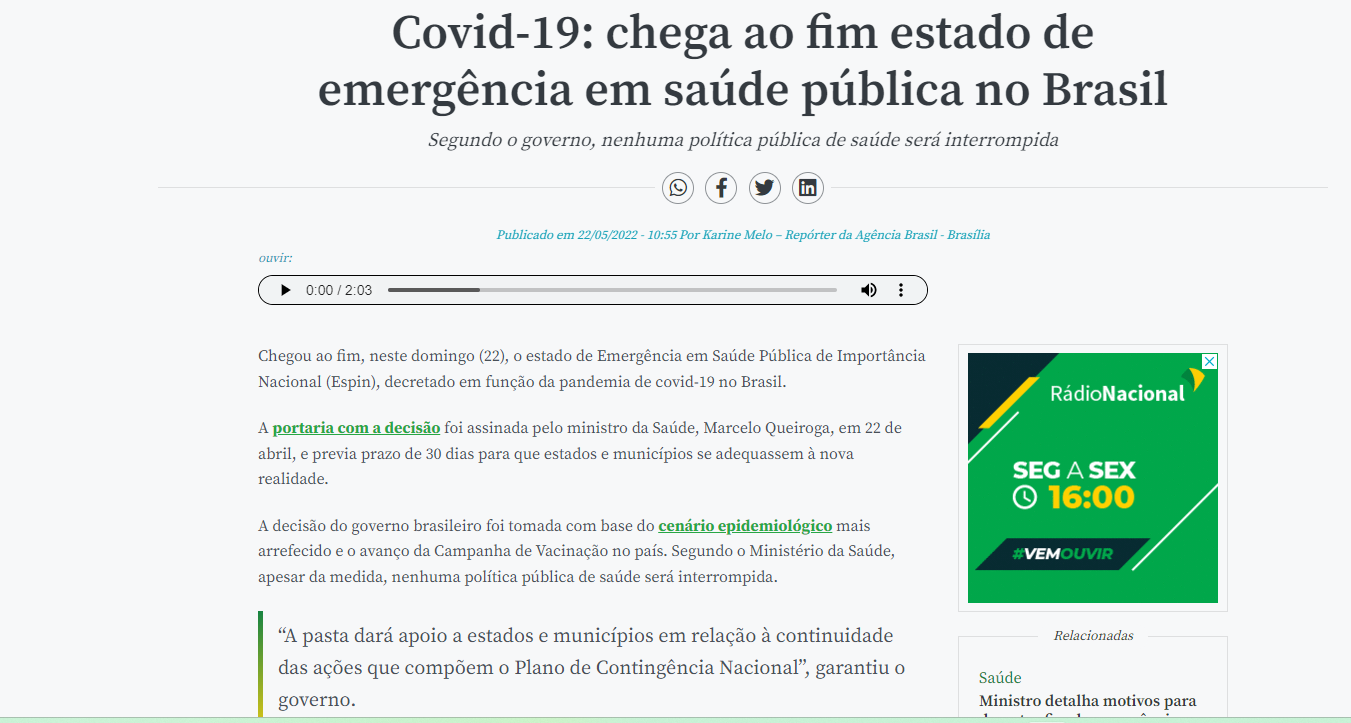


In [300]:
# Criando a coluna "Covid"
dados=dados.assign(Covid='xxx')
inicio_pandemia= pd.to_datetime('2020-03-15')
fim_pandemia=pd.to_datetime('2022-04-22')
for i in range(0,comp_dados):
    if dados['Data'][i]<inicio_pandemia:
        dados['Covid'][i]="Pré-Pandemia"
    elif dados['Data'][i]> fim_pandemia:
        dados['Covid'][i]="Pós-Pandemia"
    else:
        dados['Covid'][i]="Pandemia"
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-05           4898.88            44.80   
5            Sul 2023-07-04           5203.96            47.59   
11           Sul 2023-07-03           5562.44            50.87   
13           Sul 2023-07-02           6030.28            55.15   
19           Sul 2023-07-01           6642.92            60.76   
...          ...        ...               ...              ...   
27022   Nordeste 2005-01-05          11820.00            85.58   
27026   Nordeste 2005-01-04          11285.00            81.71   
27031   Nordeste 2005-01-03          10929.00            79.13   
27034   Nordeste 2005-01-02          10267.00            74.34   
27038   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     4767.12                  43.60  20459.24    17977.06   
5                     5097.76                  46.6

In [301]:
# Exibindo as informações do DataFrame "final", incorporada a coluna "Covid"
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27040 entries, 1 to 27038
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27040 non-null  object        
 1   Data                    27040 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27040 non-null  float64       
 3   ENA_Bruta[%MLT]         27040 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27040 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27040 non-null  float64       
 6   EAR_max                 27040 non-null  float64       
 7   EAR[MWmes]              27040 non-null  float64       
 8   EAR[%max]               27040 non-null  float64       
 9   Carga_Diaria[MWmed]     27040 non-null  float64       
 10  CMO_semanal[R$/MWh]     27040 non-null  float64       
 11  CMO_leve[R$/MWh]        27040 non-null  float64       
 12  CMO_media[R$/MWh]       27040 non-null  float6

Portanto, o dataframe "dados" possui todos os valores "não-nulos", sendo as colunas 'Subsistema' e 'Covid' qualitativas.

In [302]:
# Verificando a distribuição das classes (Covid)
dados.groupby('Covid').size()

Covid
Pandemia         3076
Pré-Pandemia    22208
Pós-Pandemia     1756
dtype: int64

Numa etapa futura, que objetivará a predição do CMO, espera-se que o período da pandemia mereça algum tipo de tratamento especial, de modo a evitar vieses incorretos nas saídas dos modelos de Machine Learning, a ser tratado nos próximos Sprints.

In [303]:
# Redefinindo os datasets por subsistema, incorporando a coluna "Covid"
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [304]:
print(dados_SE)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-05          23404.64            91.26   
4        Sudeste 2023-07-04          23858.40            93.03   
10       Sudeste 2023-07-03          24312.06            94.80   
12       Sudeste 2023-07-02          24907.82            97.13   
18       Sudeste 2023-07-01          25502.73            99.45   
...          ...        ...               ...              ...   
27020    Sudeste 2005-01-05          45324.00            90.05   
27024    Sudeste 2005-01-04          44388.00            88.19   
27029    Sudeste 2005-01-03          43314.00            86.06   
27035    Sudeste 2005-01-02          43352.00            86.13   
27036    Sudeste 2005-01-01          43952.00            87.32   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[MWmes]  \
0                    22735.20                  88.65  204615.33   176229.19   
4                    23358.95                  91

## Visualizações Unimodais

### Histogramas

In [305]:
# Histograma para visualização dos dados de ENA_Bruta[MWmed];ENA_Bruta[%MLT]; EAR[MWmes]; EAR[%max]; Carga_Diaria[MWmed] e CMO_Semanal[R$/MWh]
# Carregando o estilo "seaborn-v0_8"
plt.style.use("seaborn-v0_8")

# Alterando alguns parâmetros gráficos
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

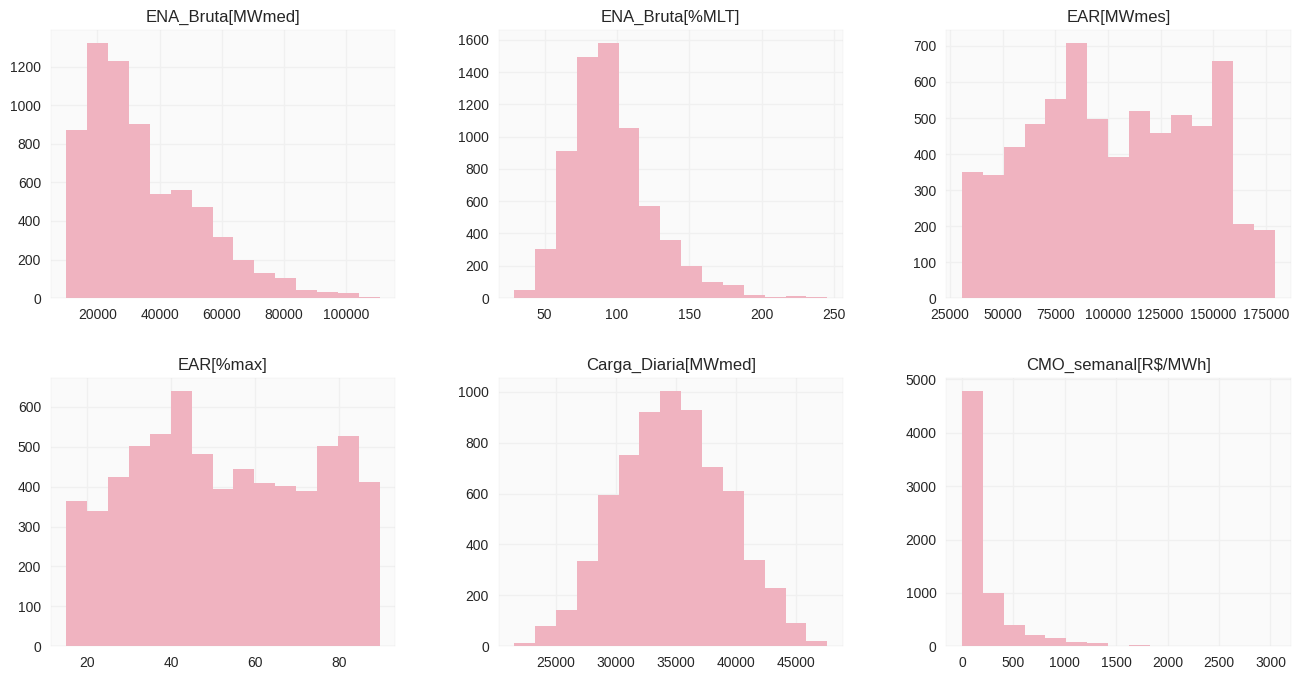

In [306]:
# Histograma Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#F0b3c0")
plt.show()

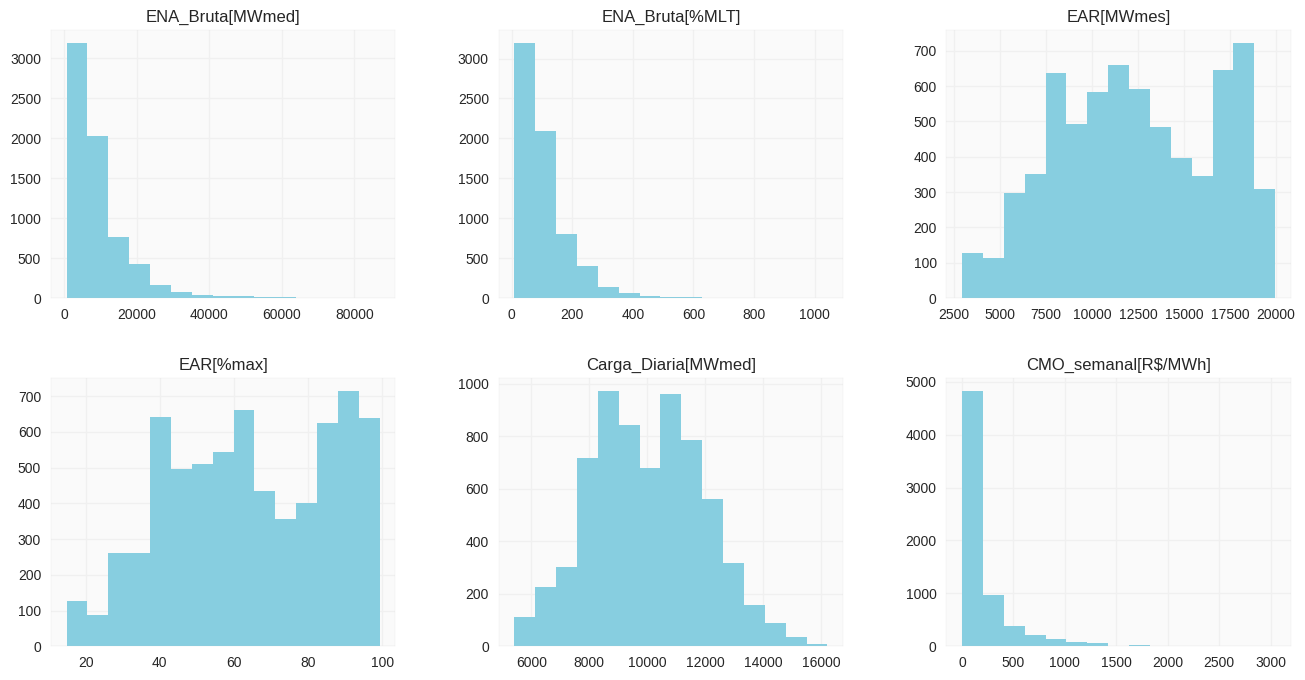

In [307]:
# Histograma Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#87cee0")
plt.bar_label
plt.show()

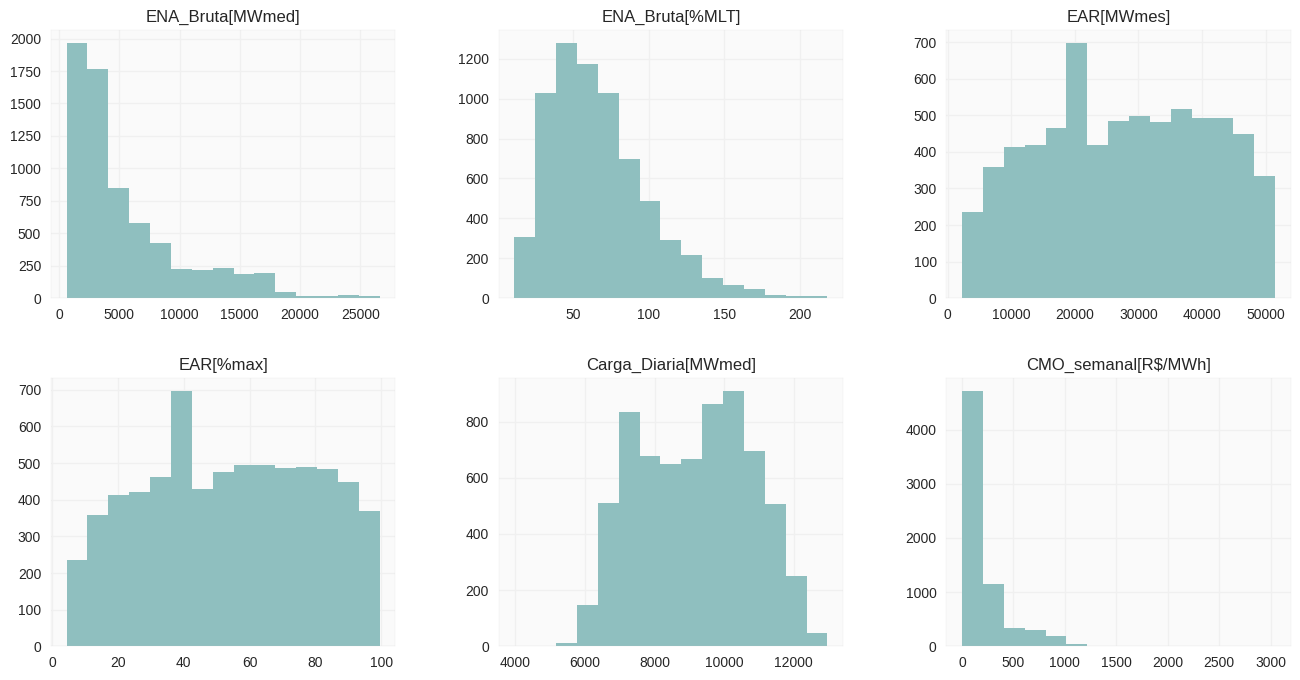

In [308]:
# Histograma Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#8FBfbF")
plt.show()

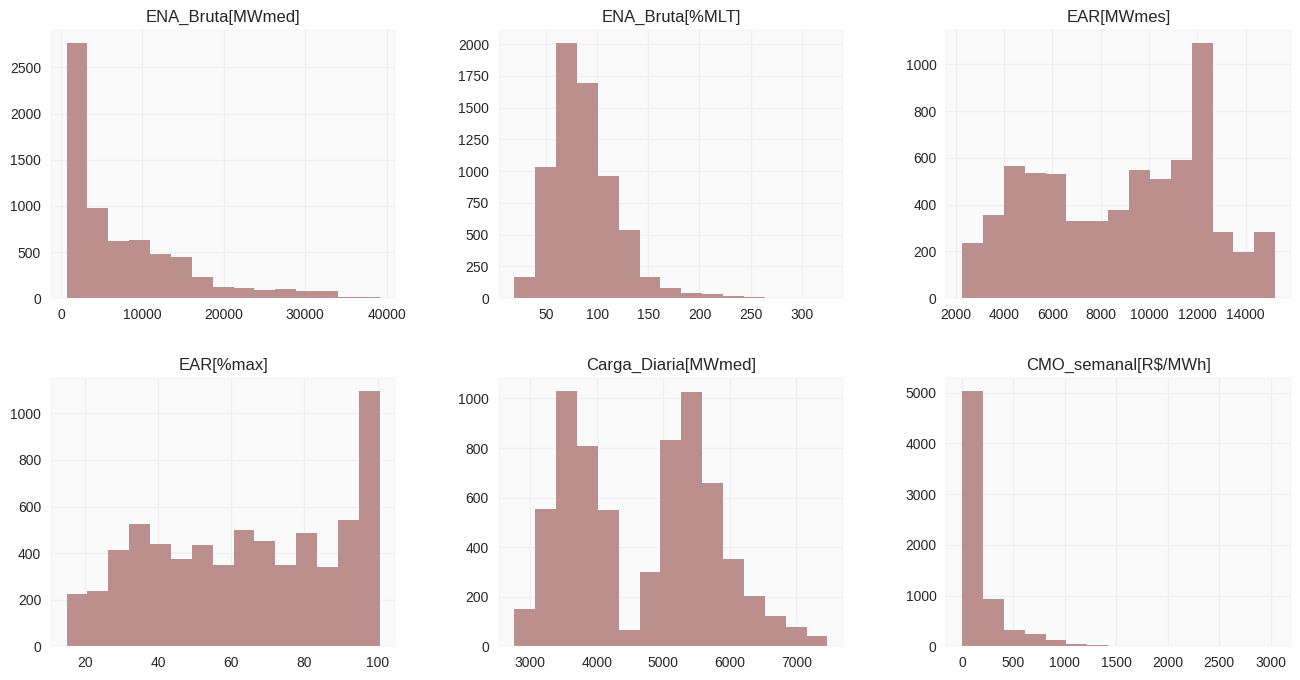

In [309]:
# Histograma Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15, layout = (2,3), figsize = (16,8), color="#BC8F8F")
plt.show()



> Pela análise dos histogramas, para todos os subsistemas o CMO semanal apresenta assimetria positiva, indicando que a enorme maioria dos valores encontra-se abaixo dos 250 Reais/MWh, embora haja valores extremos, ultrapassando os 3000 R$/MWh, conforme visto nas tabelas com as estatísticas descritivas.


> Em relação ao comportamento da carga diária, para o Sudeste, aproxima-se bastante de uma distribuição normal. Chama a atenção a carga do Norte: provavelmente, esse comportamento "dividido em dois blocos bem definidos" se deve à entrada/saída de algum grande consumidor, que faça com que a ocorrência de valores entre 4 e 5 GWmed seja baixa.


> Em relação aos reservatórios, é interessante observar como, para o subsistema Nordeste, a maior frequência de EAR (%máx) no período está na faixa dos 40%. E que Sudeste e Sul também tiveram reservatórios próximos a esse patamar em um número expressivo de dias.



> Sobre a ENA em % da MLT, todos os subsistemas apresentam assimetria à direita. Para o Sudeste, a maior frequência é próxima dos 80-100% da MLT.









### Boxplot

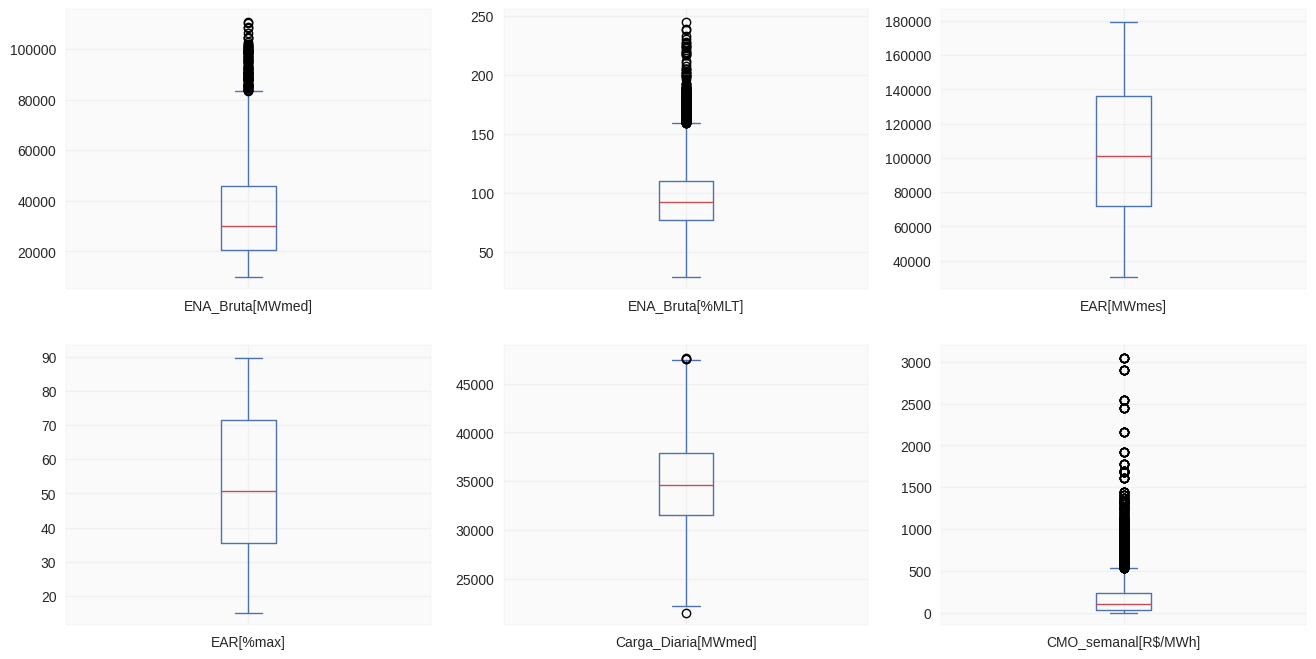

In [310]:
# Boxplot Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

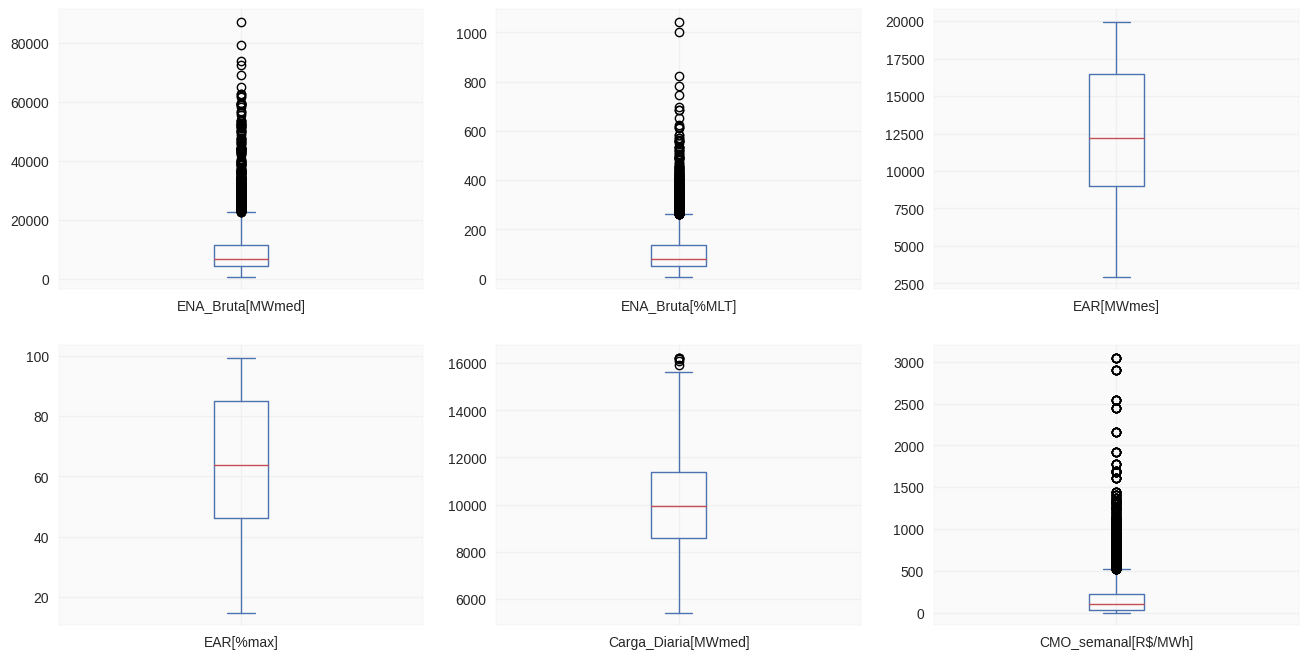

In [311]:
# Boxplot Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

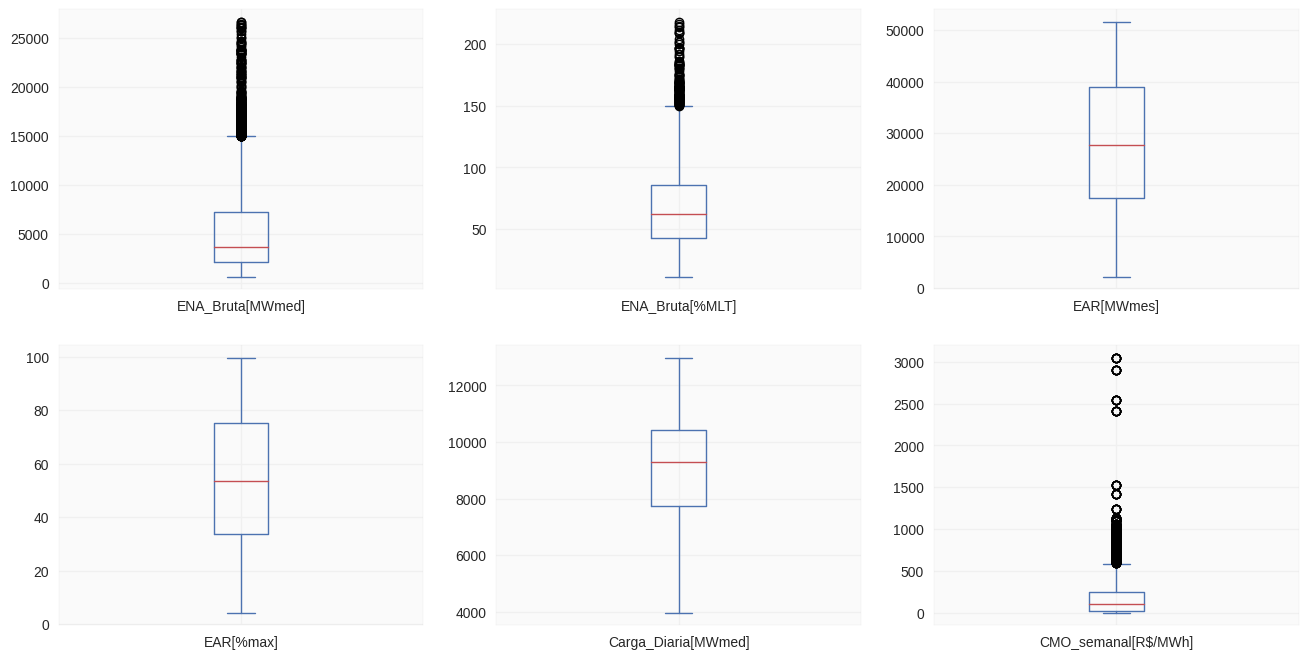

In [312]:
# Boxplot Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

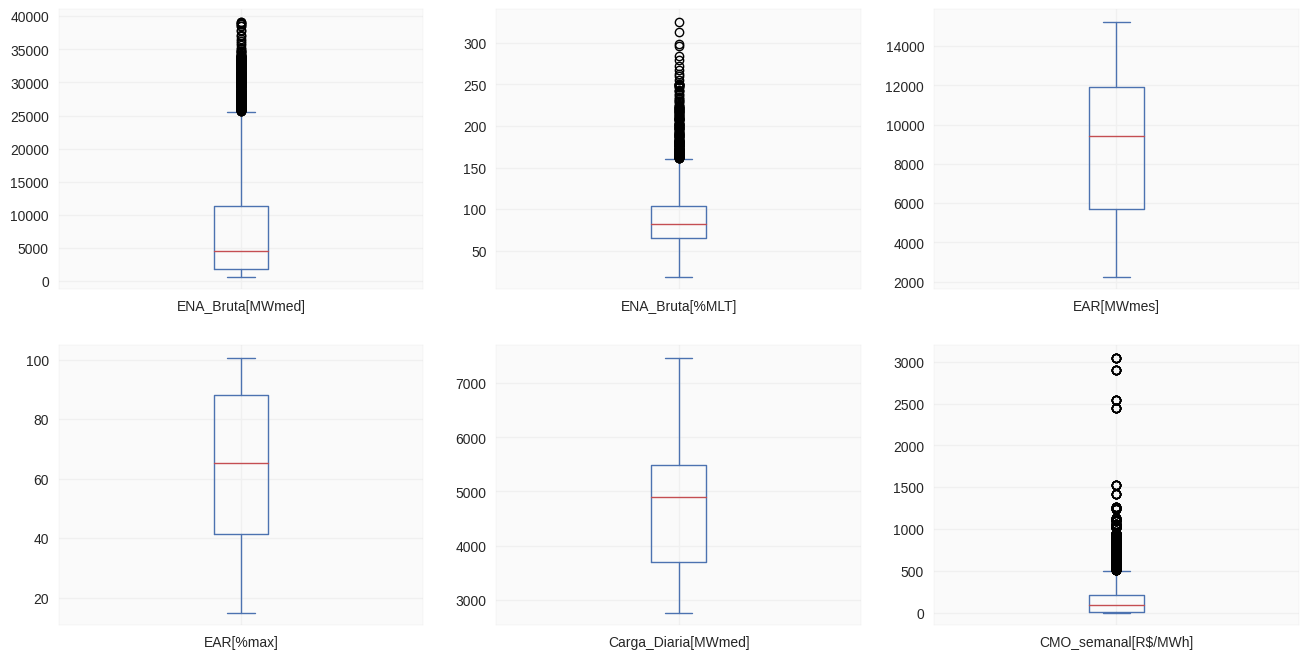

In [313]:
# Boxplot Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()



> A análise dos gráficos boxplot corrobora as constatações do histograma. Nas plotagens, a linha vermelha representa a mediana (imune a outliers). Para todos os subsistemas, observa-se que, em relação à Energia Armazenada, todos os valores encontram-se dentro dos limites do boxplot (tanto em MWmes quanto em %máximo). Este fato pode ser depreendido do histograma, pelo qual é possível perceber que não há diferenças significativas nas distribuições de probabilidade dos reservatórios, considerando um mesmo subsistema. Fato semelhante ocorre para os gráficos de carga diária. Neste ponto, destaca-se o fato de que, para a região Norte, o valor de P50 (próximo aos 5 GWmed) está bem mais próximo do valor correspondente ao terceiro quartil (P75) do que do primeiro (P25). Isso indica uma distribuição elevada de carga na faixa dos 5 ao 5,5 GWmed no referido subsistema. Para o Sul e Sudeste, alguns poucos valores acima do limite superior do intervalo.

> Em relação à ENA, no entanto, para todos os subsistemas se observam bastante valores fora dos limites do boxplot, característica das distribuições com assimetria à direita. Como destaque, para o Sul, houve uma ocorrência de ENA superior aos 1000% da MLT o que, certamente, configura um evento extremamente atípico em termos meteorológicos/climatológicos.


> Por fim, em relação ao CMO, observa-se que em 50% da amostra, os valores são inferiores a 150 Reais/MWh para os 4 subsistemas. O P75 não chega aos 250 Reais/MWh e o limite da faixa gira em torno dos 500 Reais/MWh. Nas etapas de predição/prescrição, faz-se necessário, portanto, maior atenção aos valores fora do intervalo, provavelmente correspondentes a períodos de grave escassez hídrica, como foi o biênio 2020-2021, quando os baixos valores de ENA e EArm levaram ao CMO de mais de 3000 Reais/MWh.






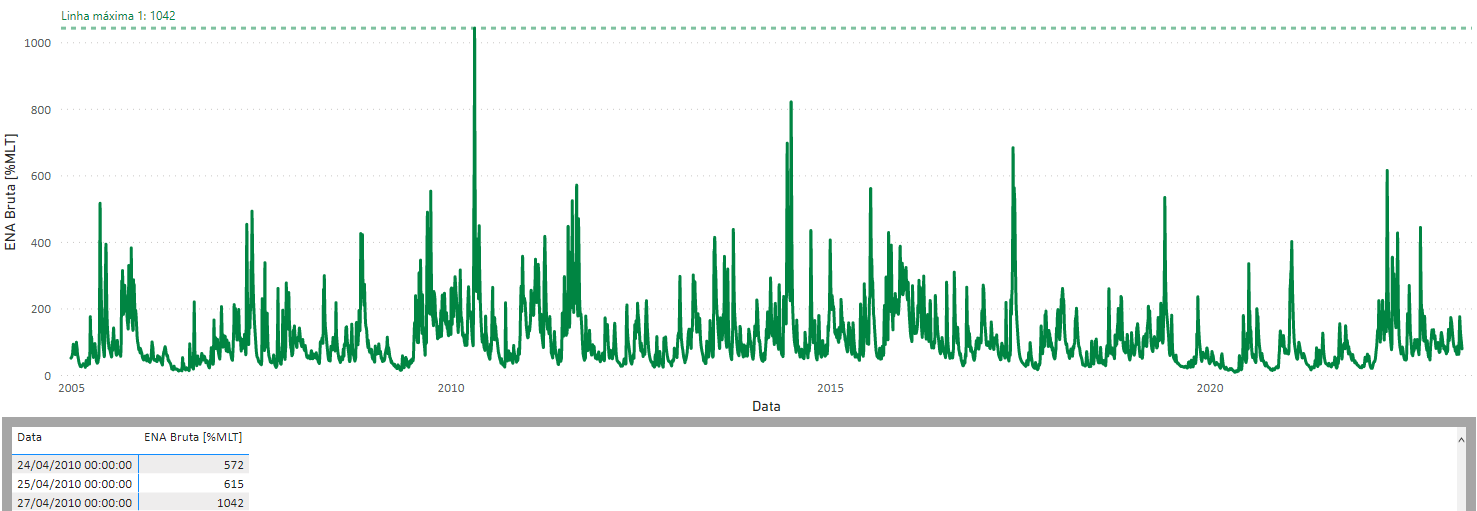
Data de ocorrência do evento de mais de 1000% da MLT na região Sul, correspondente a cerca de 60 GWmed (gráfico elaborado por meio do Power BI).

## Visualizações Multimodais

### Matriz de Correlação

<Axes: >

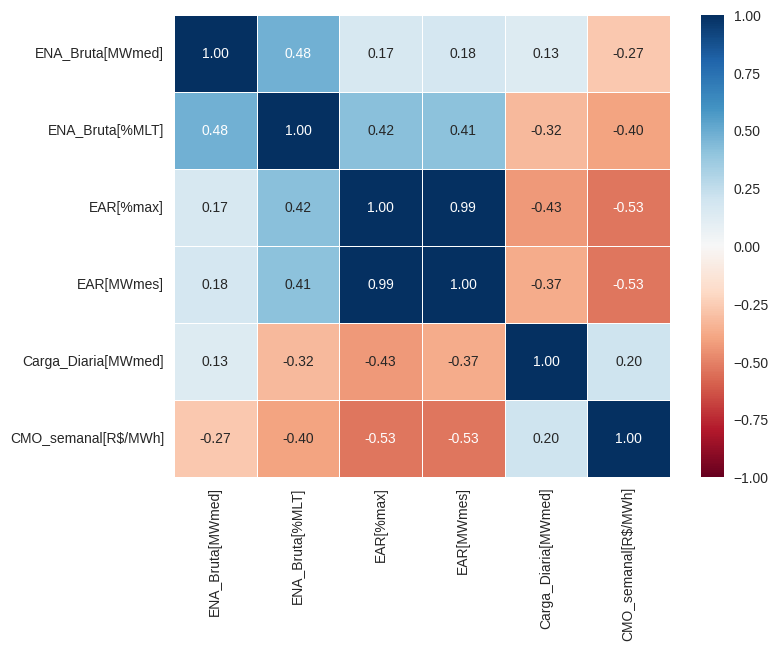

In [314]:
# Matriz de Correlação para o Sudeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

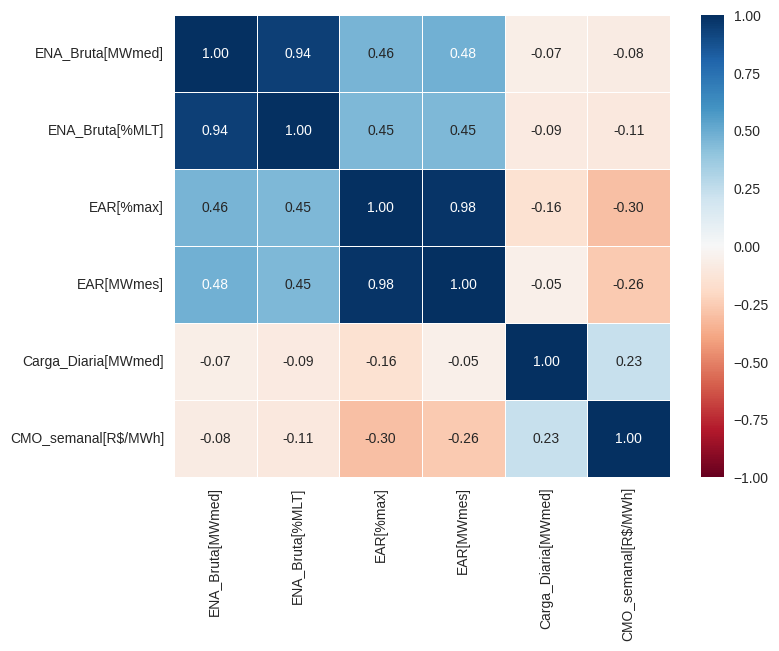

In [315]:
# Matriz de Correlação para o Sul
plt.figure(figsize=(8,6))
sns.heatmap(dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

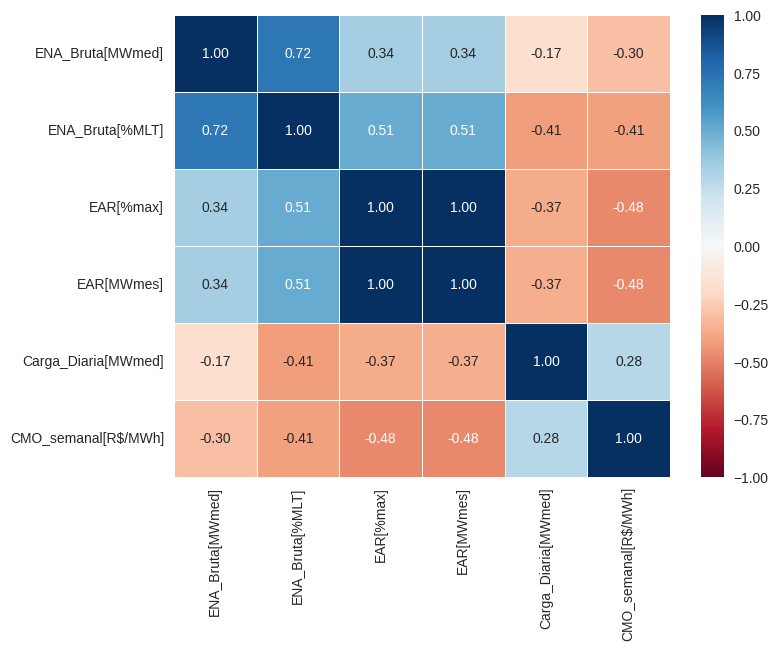

In [316]:
# Matriz de Correlação para o Nordeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

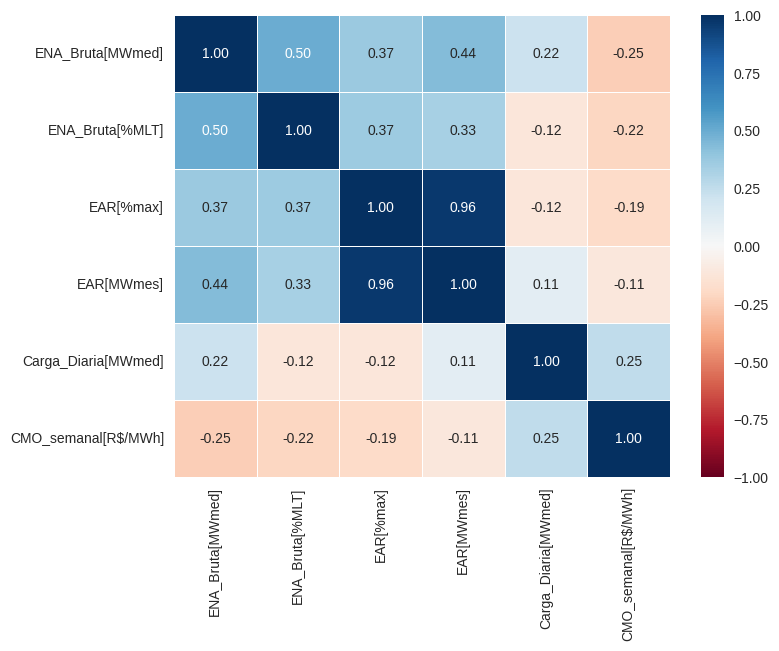

In [317]:
# Matriz de Correlação para o Norte
plt.figure(figsize=(8,6))
sns.heatmap(dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

Conforme analisado anteriormente, considerando todo o horizonte de dados disponível (2005-dias atuais), é possível identificar uma correlação moderada (negativa) do CMO com a Energia Armazenada (em % do volume útil) e com a Energia Natural Afluente (em % da MLT) principalmente para o Sudeste e o Nordeste, que são os subsistemas com maior volume máximo de reservatórios do SIN. Para a carga, a correlação é positiva moderada, em todos os subsistemas, conforme esperado "intuitivamente". É possível constatar ainda que ENA (%MLT) e EArm (%máx) se correlacionam positivamente. Esse comportamento faz sentido, uma vez que na ocorrência de chuvas (e, consequentemente, de elevação da ENA) espera-se que os reservatórios (EArm) também se encham. As políticas operativas, no entanto, podem acabar levando a maiores ou menores deplecionamentos dos reservatórios das usinas hidroelétricas, por fora dos modelos, a depender da conjuntura hidrológica e do balanço energético do Sistema Interligado Nacional.

### Scatter Plot

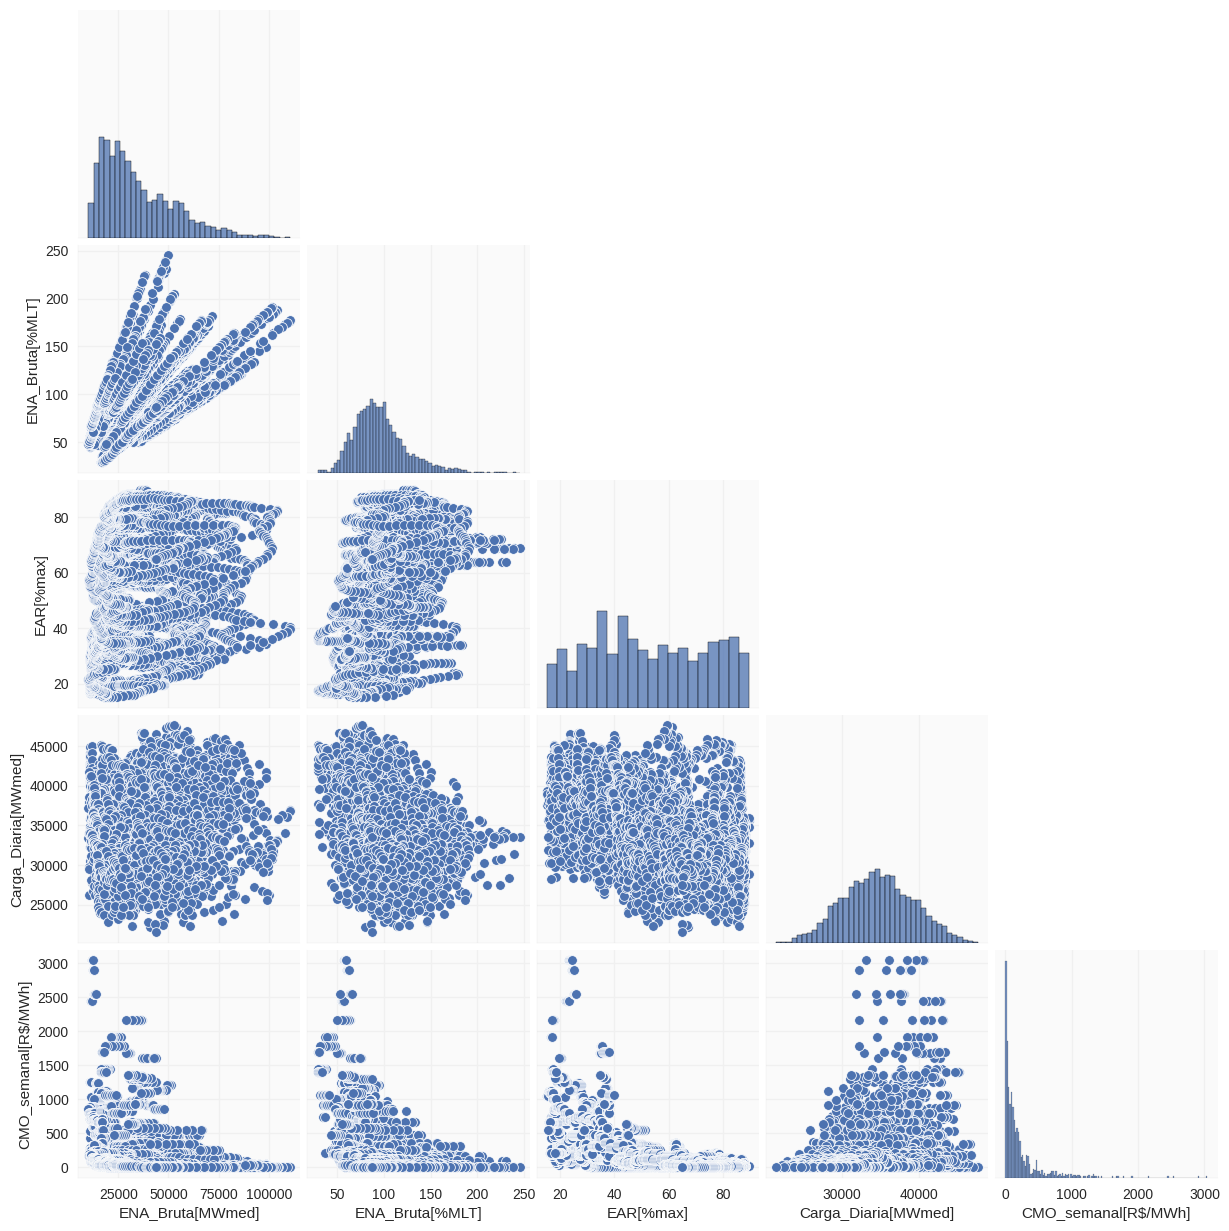

In [318]:
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
# Scatter Plot com Seaborn - Sudeste
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']], corner=True)

Pela avaliação do scatter-plot, podemos observar como os maiores valores de CMO semanal ocorrem para valores de ENA Bruta inferiores a 75% da MLT e para reservatórios abaixo dos 40% do volume útil no Sudeste. É possível observar também que o CMO de 0 R$/MWh nunca ocorreu em casos de ENA diária inferior a 50% da MLT no Sudeste. Um outro destaque é o fato de os maiores valores de CMO não terem ocorrido para valores mínimos de ENA em % da MLT (e sim próximo aos 60%), mas, para ENAs muito baixas em termos absolutos (MWmed). Isto nos leva a crer que esses Custos muito elevados se deram em algum mês de MLT mais baixa (ou seja, de valores históricos de chuva mais baixos, pela sazonalidade/climatologia. Provavelmente, entre junho e novembro, meses do chamado "período seco"). Além disso, para reservatórios superiores a 50%-55%, o CMO não ultrapassou os 500 Reais/MWh que, como vimos no Boxplot, é o limite superior do mesmo. Em relação à carga, à exceção de valores outlier de CMO, o comportamento da curva Carga x CMO parece ter uma tendência de distribuição normal, para a qual valores mais elevados de CMO ocorrem em cargas intermediárias, entre 30 e 40 GWmed. Esse comportamento não é intuitivo, a princípio. Porém, como pode ser visto no gráfico de ENA Bruta (MWmed) x Carga, os maiores valores de ENA ocorreram para cargas de aproximadamente 35 GWmed e isso poderia explicar o comportamento do CMO (embora essa relação ENA x Carga possa ser uma coincidência em função da pandemia - menor carga e El Niño - condições climáticas - menor ENA). Para trabalhos futuros, fazem-se necessárias avaliações mais detalhadas a respeito.

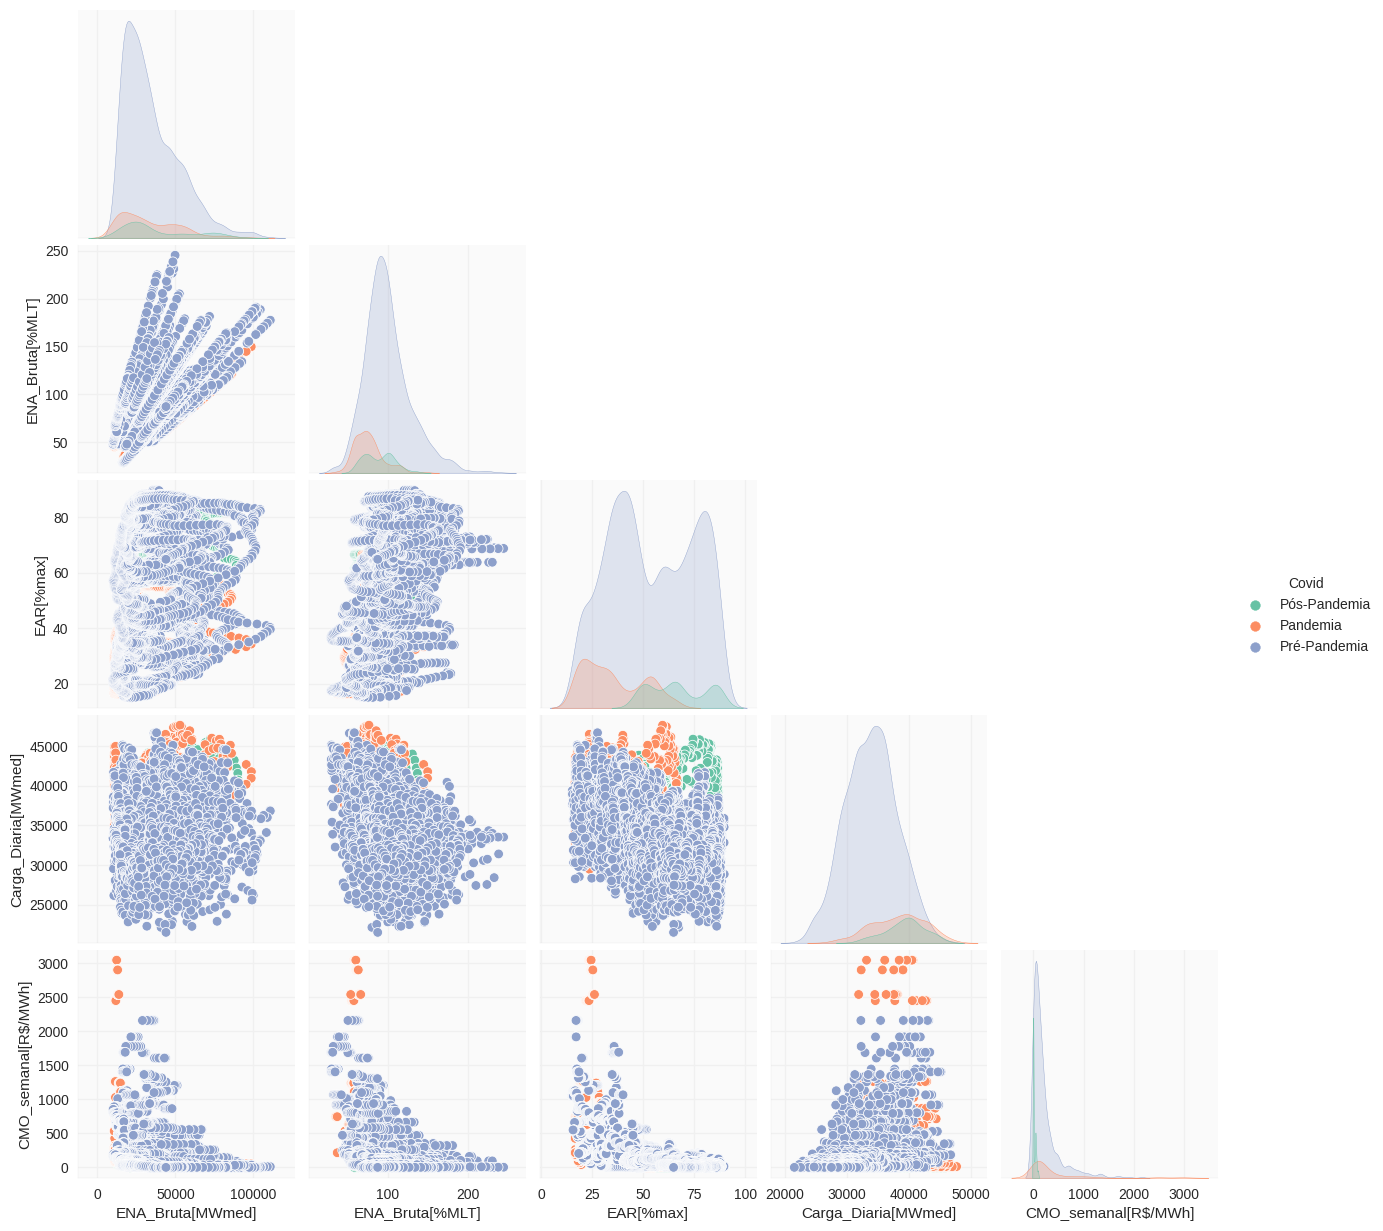

In [319]:
# Scatter Plot considerando a variável qualitativa referente à pandemia de Covid-19
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','Covid']], hue = "Covid", height = 2.5, corner=True, palette="Set2")

A principal interferência da pandemia de Covid-19 nas grandezas avaliadas diz respeito à carga. Embora, coincidentemente (mas sem nenhum tipo de relação causal), os valores de ENA (em MWmed e em % da MLT) tenham tido uma distribuição mais assimétrica à direita no período da pandemia do que no período anterior a ela. É necessário, em análises futuras (e no treinamento dos modelos de ML) cautela neste aspecto, para que os algoritmos não indiquem correlações indevidas entre a pandemia e a ENA. Em relação à carga, durante a pandemia (e no pós), o que enxergamos é um deslocamento da curva para uma assimetria mais à esquerda. Para análises futuras, é interessante avaliar os anos imediatamente anteriores à pandemia (talvez encurtar o horizonte, neste caso, por exemplo), para tentar entender melhor os efeitos. Além disso, no durante e pós-pandemia observa-se um desvio-padrão maior (da carga) em comparação aos anos prévios. Sobre a correlação com o CMO, observamos que os maiores valores de CMO registrados ocorreram durante a pandemia, mesmo para cargas intermediárias que, fora da pandemia, levaram o custo no máximo a 70% dos 3000 Reais/MWh). E este fato provavelmente se explica pelos valores mais severos de ENA e EArm no intervalo de 2020 a 2022.

## Avaliações Temporais no Power BI

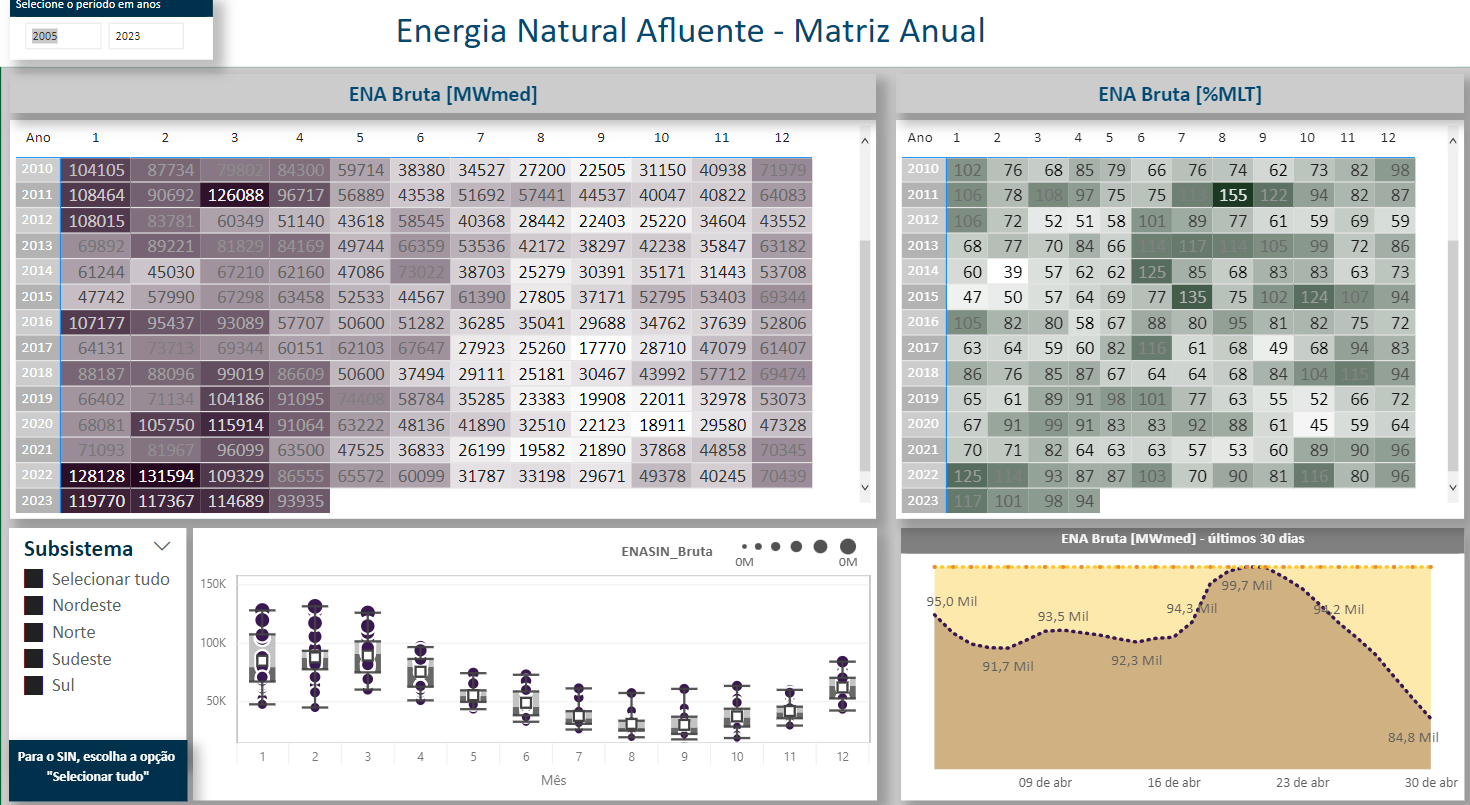

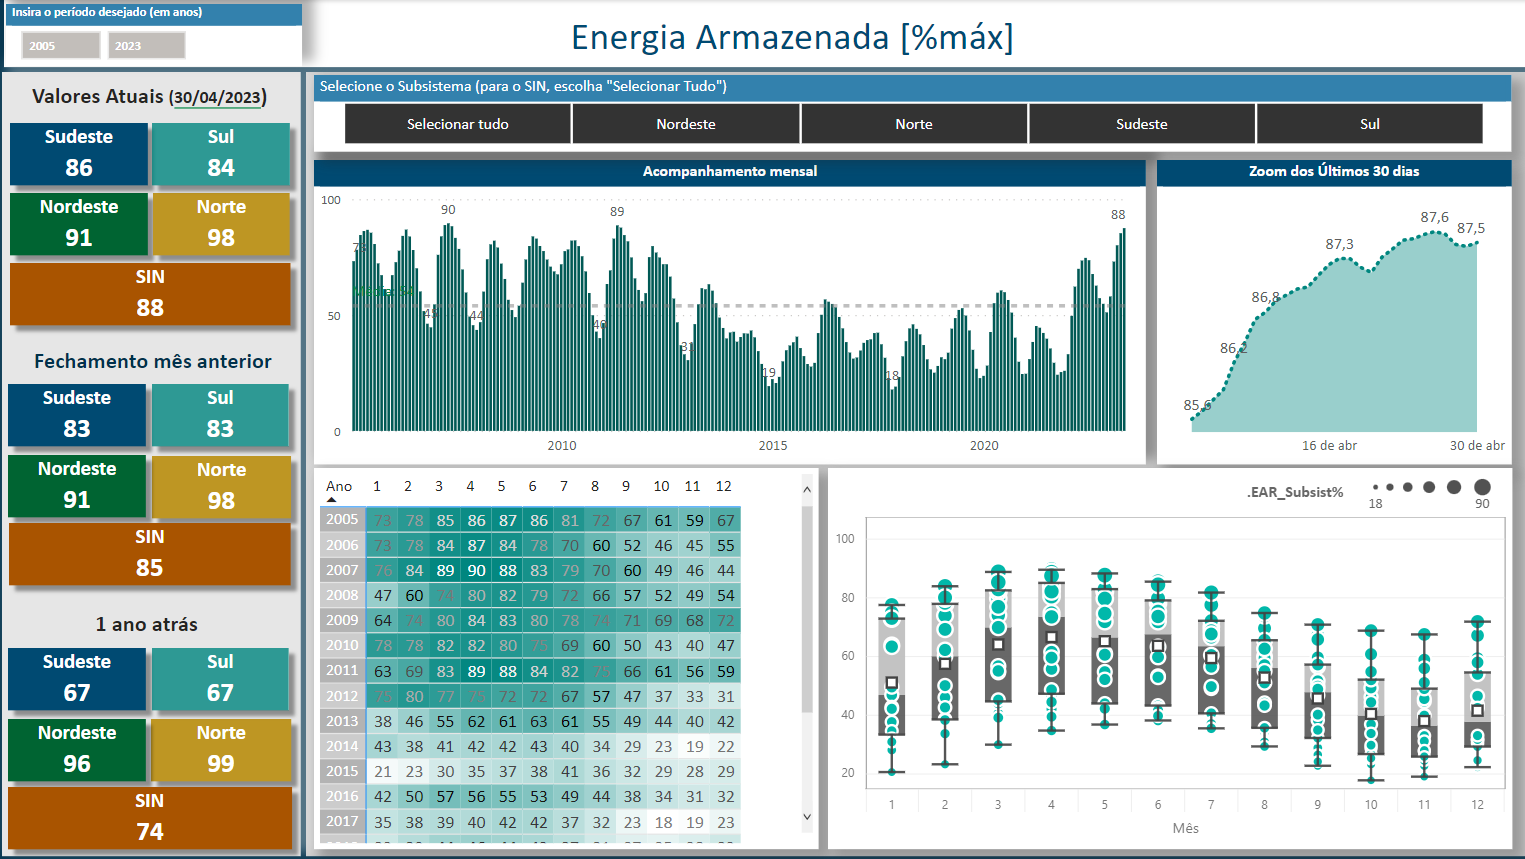

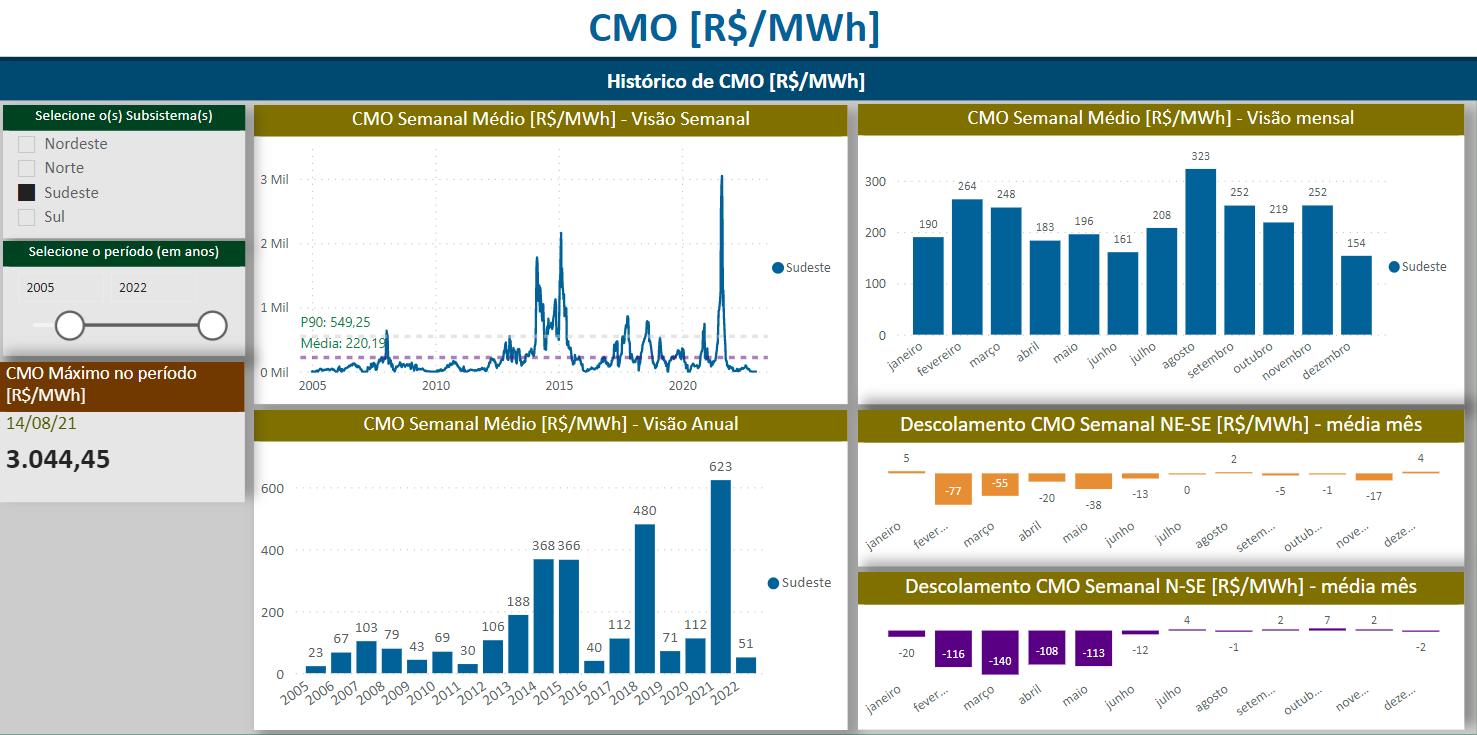

Os dados obtidos a partir da Área de Dados Abertos do ONS foram importados no Power BI (via Power Query) e, em seguida, foram gerados os dashboard acima. Pelas visualizações, pode-se concluir, por exemplo, que: desde 2011, o mês de abril não registrava ENA (% da MLT) tão alta. Além disso, pelo boxplot de ENA é possível identificar a sazonalidade do período chuvoso/seco no Brasil, de modo que dezembro a abril são os meses de maior mediana (período úmido). Em relação ao histórico recente, observa-se uma queda de mais de 10 GWmed de ENA no SIN entre o final de março e o final de abril o que é, de certa forma, esperado pela climatologia dos referidos meses. Apesar da redução da ENA (em termos absolutos) os reservatórios do SIN sofreram uma elevação no último mês. Quando comparados ao mesmo período de 2022 (30/04/23 vs 30/04/22), a crescente é muito expressiva, principalmente no Sul e no Sudeste. Podemos perceber que o enchimento/deplecionamento dos reservatórios tem um comportamento cíclico ao longo de um ano e que, desde 2011, não observávamos condições tão favoráveis de energia armazenada quanto atualmente. Em relação ao CMO médio no decorrer dos anos, observa-se que, de fato, 2011 teve valores baixíssimos do custo de operação médio. Também é possível observar que em 2021, quando as ENAs ficaram muito baixas, o preço médio anual foi o maior do histórico e que basta um ano favorável ou desfavorável em termos de chuva para alterar a tendência de CMO do ano anterior. Em relação aos valores médios nos meses, observa-se que agosto (mês de menor MLT no Sudeste) é o de maior CMO médio, ao passo que dezembro (início do período úmido), o de menor. Em relação aos valores por subsistema, observa-se que nos meses chuvosos, dentro do horizonte analisado, em geral o CMO do Nordeste e do Norte foi menor que o do Sudeste. Este aspecto está diretamente relacionado à capacidade de fluxo de energia entre os subsistemas e, considerando ampliações e reforços na transmissão, pode não ser mais replicável daqui em diante. Este aspecto não está explícito pelos dados do presente trabalho mas, em etapas futuras, faz-se pertinente a inclusão.


# **Seção IV: Pré-Processamento de Dados - Parte 2**


> Ao longo das seções/etapas anteriores, já realizamos várias atividades de pré-processamento de dados, de modo a deixar nosso DataFrame mais "enxuto", menos "redundante" e mais adequado para aplicação de Modelos de Machine Learning. Neste momento, iremos reduzir ainda mais a dimensionalidade e realizar algumas transformações numéricas.



## Redução da Dimensionalidade

In [320]:
# Reduzindo a dimensionalidade do dataset dados, excluindo as colunas de CMO por patamar
dados=dados[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_SE=dados_SE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_S=dados_S[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_NE=dados_NE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_N=dados_N[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]',]]

# Avaliando as 20 primeiras linhas do dataset dados
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-05        Sul           4898.88            44.80   
5  2023-07-04        Sul           5203.96            47.59   
11 2023-07-03        Sul           5562.44            50.87   
13 2023-07-02        Sul           6030.28            55.15   
19 2023-07-01        Sul           6642.92            60.76   
21 2023-06-30        Sul           7522.85            72.02   
25 2023-06-29        Sul           8969.36            85.87   
29 2023-06-28        Sul          10487.55           100.40   
35 2023-06-27        Sul          12597.04           120.60   
37 2023-06-26        Sul          15480.22           148.20   
41 2023-06-25        Sul          18801.98           180.00   
45 2023-06-24        Sul          19877.56           190.30   
50 2023-06-23        Sul          15156.63           145.10   
53 2023-06-22        Sul           8640.04            82.72   
57 2023-06-21        Sul           9163.54            87.73   
61 2023-06-20        Sul          10203.32            97.68   
67 2023-06-19        Sul          11749.27           112.48   
69 2023-06-18        Sul          13722.46           131.37   
73 2023-06-17        Sul          15497.13           148.36   
77 2023-06-16        Sul          14897.60           142.62   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  4767.12                  43.60  20459.24      87.87   
5                  5097.76                  46.62  20459.24      87.95   
11                 5503.06                  50.33  20459.24      87.88   
13                 5856.45                  53.56  20459.24      88.34   
19                 6579.30                  60.17  20459.24      88.42   
21                 7421.34                  71.05  20459.24      88.33   
25                 8174.18                  78.26  20459.24      88.69   
29                 7780.74                  74.49  20459.24      88.91   
35                 8767.85                  83.94  20459.24      88.70   
37                 8183.68                  78.35  20459.24      88.63   
41                 7884.29                  75.48  20459.24      88.85   
45                 9033.72                  86.48  20459.24      88.50   
50                 8708.14                  83.37  20459.24      87.32   
53                 7009.20                  67.10  20459.24      86.01   
57                 7114.31                  68.11  20459.24      85.75   
61                 8725.06                  83.53  20459.24      85.67   
67                 8196.03                  78.46  20459.24      85.12   
69                10547.37                 100.98  20459.24      84.89   
73                13598.06                 130.18  20459.24      84.11   
77                12618.48                 120.80  20459.24      82.90   

    EAR[MWmes]  Carga_Diaria[MWmed]         Covid  CMO_semanal[R$/MWh]  
1     17977.06             12879.74  Pós-Pandemia                  0.0  
5     17993.31             12745.53  Pós-Pandemia                  0.0  
11    17979.12             12326.18  Pós-Pandemia                  0.0  
13    18074.42              9695.05  Pós-Pandemia                  0.0  
19    18090.19             10884.16  Pós-Pandemia                  0.0  
21    18072.25             12594.56  Pós-Pandemia                  0.0  
25    18145.95             12230.42  Pós-Pandemia                  0.0  
29    18189.47             12324.42  Pós-Pandemia                  0.0  
35    18148.24             12097.43  Pós-Pandemia                  0.0  
37    18133.57             11717.31  Pós-Pandemia                  0.0  
41    18177.75              8993.10  Pós-Pandemia                  0.0  
45    18106.51             10182.21  Pós-Pandemia                  0.0  
50    17864.58             12567.50  Pós-Pandemia                  0.0  
53    17597.21             12967.64  Pós-Pandemia                  0.0  
57    17544.79             12720.54

In [321]:
# Confirmando novamente a ausência de dados faltantes
dados.isnull().sum()

Data                      0
Subsistema                0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[%max]                 0
EAR[MWmes]                0
Carga_Diaria[MWmed]       0
Covid                     0
CMO_semanal[R$/MWh]       0
dtype: int64

In [322]:
# Exibindo as dimensões de cada dataset
print("SIN:")
print(dados.shape)
print("Sudeste:")
print(dados_SE.shape)
print("Sul:")
print(dados_S.shape)
print("Nordeste:")
print(dados_NE.shape)
print("Norte:")
print(dados_N.shape)

SIN:
(27040, 12)
Sudeste:
(6760, 12)
Sul:
(6760, 12)
Nordeste:
(6760, 12)
Norte:
(6760, 12)


## Preparação para os Algoritmos de ML

A Normalização e a padronização são técnicas frequentemente aplicadas na etapa de preparação dos dados, com o objetivo de colocá-los em um intervalo de valores comuns. Não são técnicas obrigatórias para todos os algoritmos de Machine Learning mas podem impactar na acurácia do modelo a ser utilizado.

Alterando os dados da coluna 'Covid' de qualitativos (categóricos) para codificação ordinal, de modo que "Pré-Pandemia"=0; "Pandemia"=1 e "Pós-Pandemia"=2

In [323]:
# Armazenando os datasets com a coluna 'Covid' original
dados_pandemia=dados
dados_pandemia_SE=dados_SE
dados_pandemia_S=dados_S
dados_pandemia_NE=dados_NE
dados_pandemia_N=dados_N

In [324]:
# Aplicando Ordinal Encoding
dados['Covid']=dados['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_SE['Covid']=dados_SE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_S['Covid']=dados_S['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_NE['Covid']=dados_NE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_N['Covid']=dados_N['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-05        Sul           4898.88            44.80   
5  2023-07-04        Sul           5203.96            47.59   
11 2023-07-03        Sul           5562.44            50.87   
13 2023-07-02        Sul           6030.28            55.15   
19 2023-07-01        Sul           6642.92            60.76   
21 2023-06-30        Sul           7522.85            72.02   
25 2023-06-29        Sul           8969.36            85.87   
29 2023-06-28        Sul          10487.55           100.40   
35 2023-06-27        Sul          12597.04           120.60   
37 2023-06-26        Sul          15480.22           148.20   
41 2023-06-25        Sul          18801.98           180.00   
45 2023-06-24        Sul          19877.56           190.30   
50 2023-06-23        Sul          15156.63           145.10   
53 2023-06-22        Sul           8640.04            82.72   
57 2023-06-21        Sul           9163.54            87.73   
61 2023-06-20        Sul          10203.32            97.68   
67 2023-06-19        Sul          11749.27           112.48   
69 2023-06-18        Sul          13722.46           131.37   
73 2023-06-17        Sul          15497.13           148.36   
77 2023-06-16        Sul          14897.60           142.62   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  4767.12                  43.60  20459.24      87.87   
5                  5097.76                  46.62  20459.24      87.95   
11                 5503.06                  50.33  20459.24      87.88   
13                 5856.45                  53.56  20459.24      88.34   
19                 6579.30                  60.17  20459.24      88.42   
21                 7421.34                  71.05  20459.24      88.33   
25                 8174.18                  78.26  20459.24      88.69   
29                 7780.74                  74.49  20459.24      88.91   
35                 8767.85                  83.94  20459.24      88.70   
37                 8183.68                  78.35  20459.24      88.63   
41                 7884.29                  75.48  20459.24      88.85   
45                 9033.72                  86.48  20459.24      88.50   
50                 8708.14                  83.37  20459.24      87.32   
53                 7009.20                  67.10  20459.24      86.01   
57                 7114.31                  68.11  20459.24      85.75   
61                 8725.06                  83.53  20459.24      85.67   
67                 8196.03                  78.46  20459.24      85.12   
69                10547.37                 100.98  20459.24      84.89   
73                13598.06                 130.18  20459.24      84.11   
77                12618.48                 120.80  20459.24      82.90   

    EAR[MWmes]  Carga_Diaria[MWmed]  Covid  CMO_semanal[R$/MWh]  
1     17977.06             12879.74      2                  0.0  
5     17993.31             12745.53      2                  0.0  
11    17979.12             12326.18      2                  0.0  
13    18074.42              9695.05      2                  0.0  
19    18090.19             10884.16      2                  0.0  
21    18072.25             12594.56      2                  0.0  
25    18145.95             12230.42      2                  0.0  
29    18189.47             12324.42      2                  0.0  
35    18148.24             12097.43      2                  0.0  
37    18133.57             11717.31      2                  0.0  
41    18177.75              8993.10      2                  0.0  
45    18106.51             10182.21      2                  0.0  
50    17864.58             12567.50      2                  0.0  
53    17597.21             12967.64      2                  0.0  
57    17544.79             12720.54      2                  0.0  
61    17528.37             12324.70      2                  0.0  
67    17

In [325]:
# Adicionando uma coluna referente ao dia da semana correspondente à data

dados=dados.assign(Dia_da_semana=1)
dados=dados.assign(Numero_da_semana=100000)
dados=dados.sort_values('Data',ascending=True)
for i in range(0,comp_dados):
    dados['Dia_da_semana'][i]=dados['Data'][i].weekday() #Por esta lógica, as segundas recebem o índice 0  e os domingos, 6
# Para retratar semanas operativas, que vão do sábado à sexta da semana seguinte, é interessante que os sábados correspondam ao 0, domingos ao 1...sexta-feira corresponda a 6:
    if dados['Dia_da_semana'][i]<5:   #(de segunda a sexta-feira)
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]+2
       dados['Numero_da_semana'][i]=dados['Data'][i].week
    else:    #(sábado e domingo)
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]-5
       dados['Numero_da_semana'][i]=dados['Data'][i].week+1
print(dados)


            Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
27036 2005-01-01    Sudeste          43952.00            87.32   
27039 2005-01-01      Norte           4157.00            50.75   
27037 2005-01-01        Sul           2812.00            50.65   
27038 2005-01-01   Nordeste          10222.00            74.01   
27032 2005-01-02        Sul           2814.00            50.69   
...          ...        ...               ...              ...   
6     2023-07-04   Nordeste           2065.94            54.73   
2     2023-07-05   Nordeste           2068.46            54.79   
3     2023-07-05      Norte           5215.49            99.14   
0     2023-07-05    Sudeste          23404.64            91.26   
1     2023-07-05        Sul           4898.88            44.80   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[%max]  \
27036                40017.00                  79.51  177852.00      64.78   
27039                 4157.00                  50.7

A variável que pretendemos predizer é o CMO Semanal Médio. Para tal, dividiremos nosso dataset por cada um dos subsistemas, considerando os subconjuntos de treino, teste e validação.

Por se tratar de uma variável numérica, contínua, utilizaremos algoritmos de Machine Learning destinados a problemas de regressão.

In [326]:
# Separando cada dataset (por subsistema) em componentes de "entrada" e "saída"
# A variável de interesse é o CMO Semanal Médio [R$/MWh]
# A data não será considerada

# SIN
array=dados.values
X= array[:,1:11] # atributos
y=array[:,11] # classe (target)
# Sudeste
X_SE= dados_SE.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_SE=dados_SE.values[:,11]  # classe (target)
# Sul
X_S= dados_S.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_S=dados_S.values[:,11]  # classe (target)
# Nordeste
X_NE= dados_NE.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_NE=dados_NE.values[:,11]  # classe (target)
# Norte
X_N= dados_N.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_N=dados_N.values[:,11]  # classe (target)

Neste momento, realizaremos a análise apenas para o subsistema Sudeste, uma vez que responde por mais de 60% da carga do Sistema Interligado Nacional e por mais de 70% da capacidade de armazenamento. Portanto, será realizada etapa de normalização e padronização dos dados quantitativos do dataset dados_SE

### Normalização dos Dados

In [327]:
# Normalizando os dados
rescaledX_norm = MinMaxScaler().fit_transform(X_SE)

# Exibindo os dados transformados
print("Dados Originais: \n\n", dados_SE.values)
print("\nDados Normalizados (não inclui a coluna class): \n\n", rescaledX_norm)

Dados Originais: 

 [[Timestamp('2023-07-05 00:00:00') 'Sudeste' 23404.64 ... 38814.17 2 0.0]
 [Timestamp('2023-07-04 00:00:00') 'Sudeste' 23858.4 ... 38576.44 2 0.0]
 [Timestamp('2023-07-03 00:00:00') 'Sudeste' 24312.06 ... 37692.05 2 0.0]
 ...
 [Timestamp('2005-01-03 00:00:00') 'Sudeste' 43314.0 ... 27491.97 0 0.0]
 [Timestamp('2005-01-02 00:00:00') 'Sudeste' 43352.0 ... 22535.16 0 0.0]
 [Timestamp('2005-01-01 00:00:00') 'Sudeste' 43952.0 ... 21533.06 0 0.0]]

Dados Normalizados (não inclui a coluna class): 

 [[0.13291687 0.28786967 0.18055384 ... 0.97903209 0.66203565 1.        ]
 [0.1374206  0.29606146 0.18858771 ... 0.98017853 0.65292827 1.        ]
 [0.14192334 0.30425325 0.19742246 ... 0.980528   0.61904747 1.        ]
 ...
 [0.33052446 0.2638034  0.43522669 ... 0.57079119 0.22828458 0.        ]
 [0.33090162 0.26412737 0.40982741 ... 0.56988943 0.03839024 0.        ]
 [0.33685684 0.26963484 0.40314271 ... 0.56840221 0.         0.        ]]


### Padronização dos Dados

In [328]:
# Padronizando os dados
rescaledX_padr = StandardScaler().fit_transform(X_SE)

# Exibindo os dados transformados
print("Dados Originais: \n\n", dados_SE.values)
print("\nDados Padronizados (não inclui a coluna class): \n\n", rescaledX_padr)

Dados Originais: 

 [[Timestamp('2023-07-05 00:00:00') 'Sudeste' 23404.64 ... 38814.17 2 0.0]
 [Timestamp('2023-07-04 00:00:00') 'Sudeste' 23858.4 ... 38576.44 2 0.0]
 [Timestamp('2023-07-03 00:00:00') 'Sudeste' 24312.06 ... 37692.05 2 0.0]
 ...
 [Timestamp('2005-01-03 00:00:00') 'Sudeste' 43314.0 ... 27491.97 0 0.0]
 [Timestamp('2005-01-02 00:00:00') 'Sudeste' 43352.0 ... 22535.16 0 0.0]
 [Timestamp('2005-01-01 00:00:00') 'Sudeste' 43952.0 ... 21533.06 0 0.0]]

Dados Padronizados (não inclui a coluna class): 

 [[-0.62508164 -0.16801063 -0.59766911 ...  1.880879    0.90360382
   3.13355866]
 [-0.60023259 -0.10596853 -0.55549581 ...  1.88526406  0.85113088
   3.13355866]
 [-0.57538902 -0.04392642 -0.50911836 ...  1.88660074  0.65592395
   3.13355866]
 ...
 [ 0.46520555 -0.35028122  0.73921943 ...  0.31938419 -1.59548801
  -0.4346813 ]
 [ 0.46728653 -0.34782758  0.60588757 ...  0.31593503 -2.68957956
  -0.4346813 ]
 [ 0.50014406 -0.30611565  0.57079668 ...  0.31024649 -2.91076802
  -0.4

In [329]:
# Dividindo os dados nos subconjuntos de treino e teste (20% dos dados serão utilizados para teste)
X_train,X_test,y_train,y_test= train_test_split(X_SE, y_SE, test_size=0.20, random_state=7)

# Criando os folds para validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

LR: MSE 70701.50 (7289.54) - RMSE 265.90
Ridge: MSE 70701.47 (7289.58) - RMSE 265.90
Lasso: MSE 70881.63 (7300.83) - RMSE 266.24
KNN: MSE 30948.40 (6018.53) - RMSE 175.92
CART: MSE 12330.55 (3977.27) - RMSE 111.04
SVM: MSE 96342.50 (10633.96) - RMSE 310.39


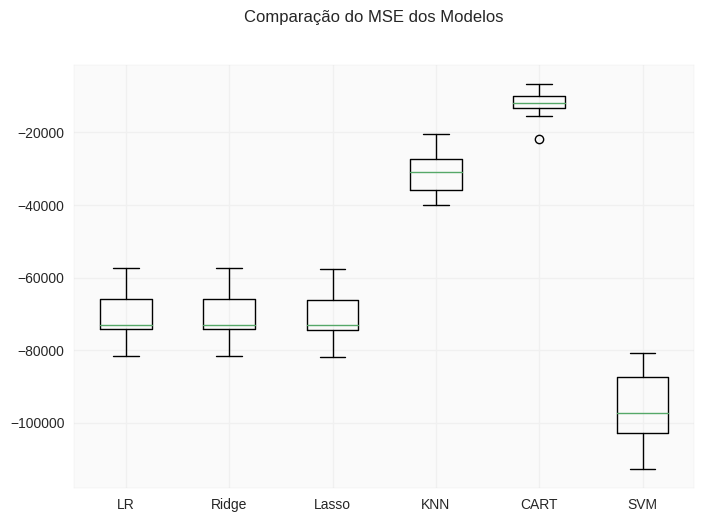

In [330]:
# Modelagem

# Definindo uma semente global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


> Avaliando o boxplot de comparação dos valores de MSE e do RMSE (mais fácil de analisar, justamente por estar na mesma dimensão - R$/MWh - que a variável target) para cada um dos métodos de regressão elencados, observa-se que o algoritmo de Árvore de Decisão (CART) se mostra consideravelmente mais promissor que os demais para o problema de predição do Custo Marginal da Operação a partir de grandezas relevantes (Energia Natural Afluente, Energia Armazenada e Demanda Energética). Nesse caso, construiremos um novo modelo, treinado com toda a base de treino.




In [331]:
# Criando um modelo com todo o conjunto de treino
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 12004.50
RMSE 109.57




> Embora o modelo de Árvore de Decisão tenha se mostrado, numa primeira análise, melhor do que os demais, as métricas de erro (MSE e RMSE) ainda podem ser reavaliadas. Para tal, podemos lançar mão de técnicas avançadas de Aprendizado Supervisionado, considerando a possibilidade de utilizarmos métodos "ensemble" e a seleção de features na tentativa de alcançarmos melhores predições.



# **Seção V: Técnicas Avançadas para Aprendizado Supervisionado**


> Inicialmente, vamos novamente separar o dataset em conjuntos de treino e teste, mas com holdout. Manteremos a abordagem que considera apenas o subsistema Sudeste.



In [332]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dados_SE.values
X_SE = array[:,1:11]
y_SE = array[:,11] # variável target: CMO médio semanal
X_train, X_test, y_train, y_test = train_test_split(X_SE, y_SE,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y_SE) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy' # inicialmente, a métrica avaliada será a acurácia
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência


In [334]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Definindo os parâmetros para o BaggingClassifier
base = DecisionTreeRegressor()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=300)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os à lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

ValueError: ignored

# **Seção VI: Conclusão**

O presente trabalho teve como objetivo a obtenção, tratamento e análise dos dados históricos de Energia Natural Afluente, Energia Armazenada, Demanda Elétrica e Custo Marginal da Operação, a partir dos dados diários por subsistema publicados pelo Operador Nacional do Sistema Elétrico. Puderam-se observar os comportamentos das referidas grandezas no período de 2005 a abril/2023, tanto ao longo do tempo, quanto em termos de distribuição (unimodal). Além disso, também foi possível avaliar as correlações entre as mesmas.

As etapas até aqui realizadas visam a, em um próximo momento, possibilitar a elaboração de algoritmos de aprendizagem de máquina no intuito de levar a predições/prescrições sobre expectativas de Custo Marginal da Operação frente a cenários futuros de ENA, EArm e Carga, considerando o histórico das mesmas e do próprio CMO.